In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..

--2025-12-30 09:39:45--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-12-30 09:39:45--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet-dal.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-12-30 09:39:45--  http://cytranet-dal

In [2]:
!pip install ta-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.0 MB/s eta 0:00:00


In [3]:
import yfinance as yf
from datetime import datetime, timedelta

print("Fetching HSI data...")
ticker = yf.Ticker("^HSI")
end_date = datetime.now()+timedelta(days=1)
start_date = end_date - timedelta(days=20*365)
df = ticker.history(start=start_date, end=end_date)
df.tail()


Fetching HSI data...


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-12-22 00:00:00+08:00,25795.939453,25859.609375,25671.330078,25801.769531,2362100000,0.0,0.0
2025-12-23 00:00:00+08:00,25875.849609,25927.660156,25726.449219,25774.140625,2240900000,0.0,0.0
2025-12-24 00:00:00+08:00,25780.089844,25890.869141,25772.869141,25818.929688,1236300000,0.0,0.0
2025-12-29 00:00:00+08:00,25928.890625,26082.939453,25630.750000,25635.230469,2931600000,0.0,0.0
2025-12-30 00:00:00+08:00,25636.400391,25930.220703,25611.230469,25854.599609,0,0.0,0.0


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import talib
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ============================================================
# STEP 0: DATA FETCHING & PREPROCESSING
# ============================================================
print("Fetching HSI data...")
ticker = yf.Ticker("^HSI")
end_date = datetime.now()+timedelta(days=1)
start_date = end_date - timedelta(days=20*365)
df = ticker.history(start=start_date, end=end_date)
print(f"最新日期: {df.index[-1].strftime('%Y-%m-%d')}")

# 1. 波动率指数 (VHSI)
print("Fetching HSIL (Volatility Index) data...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)

if vix_df.empty:
    print("⚠️ Warning: ^HSIL data is missing. Using default volatility fallback.")
    df['VIX_Close'] = 20.0 # 兜底方案：基于历史长期中位数填充
else:
    # 外部数据强制滞后一期，确保仅利用截止昨日的信息预测今日
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
    df['VIX_Close'] = df['VIX_Close'].ffill(limit=5)
    vix_fallback = df['VIX_Close'].rolling(20, min_periods=1).mean()
    df['VIX_Close'] = df['VIX_Close'].fillna(vix_fallback).fillna(20.0)

# 基础清洗
df = df.dropna(subset=['Close'])
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
last_3_days = df.index[-3:]
df = df[(df['Volume'] > 0) | (df.index.isin(last_3_days))].copy()
df.index = pd.to_datetime(df.index).tz_localize(None)

# 2. 获取外部资产数据
print("Fetching External Assets...")
tickers_dict = {
    'SPX_Close': '^GSPC',
    'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F',
    'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X',
    'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F'
}

for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if ext_df.empty:
            print(f"    ⚠️ Warning: {col_name} data is empty/sparse.")
            df[col_name] = np.nan
        else:
            # 同样强制滞后一期，防止利用跨市场时区差异引入未来数据
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
    except Exception as e:
        print(f"    ❌ Error fetching {ticker_symbol}: {e}")
        df[col_name] = np.nan

# 3. 填充外部数据
# 严禁使用 bfill，防止未来数据回填导致回测结果虚高
df[list(tickers_dict.keys())] = df[list(tickers_dict.keys())].ffill()

# 4. 计算外部资产收益率
# 显式指定 fill_method=None 以避免 Pandas 2.0+ 版本警告
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

print("External data fetched and merged.")
print(f"Data shape: {df.shape}")


# ============================================================
# STEP 1: DEFINE TRADING PATTERNS (CORRECTED LOGIC)
# ============================================================
def detect_trading_patterns(df):
    df = df.copy()
    patterns = pd.DataFrame(index=df.index)

    # 0. 准备基础数据 (Float64)
    open_p = df['Open'].values.astype(np.float64)
    high_p = df['High'].values.astype(np.float64)
    low_p = df['Low'].values.astype(np.float64)
    close_p = df['Close'].values.astype(np.float64)
    volume_p = df['Volume'].values.astype(np.float64)

    # 1. 基础收益率
    df['Returns'] = df['Close'].pct_change(fill_method=None).fillna(0)
    patterns['Returns'] = df['Returns']
    # Log Return 用于计算
    patterns['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)).fillna(0)

    # 2. 波动率基准 (ATR)
    atr_20 = talib.ATR(high_p, low_p, close_p, timeperiod=20)
    atr_20_s = pd.Series(atr_20, index=df.index)
    patterns['Volatility_Ratio'] = atr_20_s / (atr_20_s.rolling(20, min_periods=20).mean().shift(1) + 1e-10)

    # 3. 跳空缺口 (Gaps)
    prev_close = df['Close'].shift(1)
    prev_atr = atr_20_s.shift(1)
    gap_raw = (df['Open'] - prev_close) / prev_close
    gap_threshold = (prev_atr / prev_close * 0.5).fillna(1.0)
    patterns['Gap_Up'] = (gap_raw > 0).astype(float) * gap_raw * (gap_raw > gap_threshold).astype(float)
    patterns['Gap_Down'] = (gap_raw < 0).astype(float) * abs(gap_raw) * (abs(gap_raw) > gap_threshold).astype(float)

    # =======================================================
    #  4. 成交量因子 (Volume Factors - Dual Horizon & Regimes)
    # =======================================================

    # --- A. 基础计算：双时间窗口基准 ---
    # 20日均量：捕捉中期趋势 (机构视角)
    vol_ma_20 = df['Volume'].rolling(window=20, min_periods=5).mean()
    # 5日均量：捕捉短期突变 (游资/事件视角)
    vol_ma_5 = df['Volume'].rolling(window=5, min_periods=3).mean()

    # 相对量能 (Relative Volume) - 连续型指标
    # 使用 20 日作为主基准，描述整体热度
    patterns['Vol_Rel_20'] = (df['Volume'] / (vol_ma_20 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)
    # 使用 5 日作为敏捷基准，描述短期爆发力
    patterns['Vol_Rel_5'] = (df['Volume'] / (vol_ma_5 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)

    # --- B. 状态信号：自适应阈值 ---
    # 极度放量 (Relative > 2.0)
    patterns['Vol_Surge'] = (patterns['Vol_Rel_20'] > 2.0).astype(float)
    # 明显缩量 (Relative < 0.6)
    patterns['Vol_Dry_Up'] = (patterns['Vol_Rel_20'] < 0.6).astype(float)

    # --- C. 量价逻辑拆分 ---
    # 上涨放量 (Bullish Force): 价格涨 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Up_Confirm'] = (
        (patterns['Log_Ret'] > 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 下跌放量 (Panic Selling): 价格跌 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Down_Panic'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 缩量回调 (Healthy Pullback): 价格跌 但 量能小于 5日均线 (短期缩量)
    patterns['Vol_Pullback_Low'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_5'] < 0.8)
    ).astype(float)

    # --- D. 量价偏差与连续性 ---
    # 量能偏差 (连续变量): 正值代表放量，负值代表缩量
    patterns['Vol_Bias_20'] = (patterns['Vol_Rel_20'] - 1.0)

    # 量价趋势一致性 (3日窗口)
    # 逻辑：价格变化方向 == 成交量变化方向 (涨且增量，或跌且缩量)
    vol_diff = df['Volume'].diff()
    price_diff = df['Close'].diff()

    is_up_vol = (price_diff > 0) & (vol_diff > 0)
    is_down_dry = (price_diff < 0) & (vol_diff < 0)

    # 3天内符合“顺势量价”的天数 (0, 1, 2, 3)
    patterns['Vol_Trend_Consistency'] = (is_up_vol | is_down_dry).rolling(3).sum().fillna(0)

    # 兼容性别名 (供后续旧代码逻辑引用)
    patterns['Vol_Rel'] = patterns['Vol_Rel_20']
    patterns['High_Volume'] = patterns['Vol_Surge']

    # =======================================================

    # 5. 反转形态
    # 更新：使用新的 Vol_Rel_20 替代
    avg_vol_20 = vol_ma_20 # 复用变量
    patterns['Gap_Up_Reversal'] = (
        (patterns['Gap_Up'] > 0.005) & (df['Close'] < df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Up']

    patterns['Gap_Down_Reversal'] = (
        (patterns['Gap_Down'] > 0.005) & (df['Close'] > df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Down']

    # 6. 趋势连续性
    patterns['Trend_2Day'] = df['Log_Ret'].rolling(2).sum().fillna(0)
    t2_sign = np.sign(patterns['Trend_2Day'])
    patterns['Trend_Consistency'] = ((t2_sign == t2_sign.shift(1)) & (t2_sign == t2_sign.shift(2))).astype(float).fillna(0)

    # 7. 回撤反弹
    rolling_max = df['Close'].rolling(20).max().shift(1)
    drawdown = (df['Close'].shift(1) - rolling_max) / (rolling_max + 1e-10)
    drawdown_5pct = drawdown.rolling(10).quantile(0.1).fillna(-0.05)
    patterns['Drawdown_Bounce'] = ((drawdown < drawdown_5pct) & (df['Returns'] > 0.01)).astype(float) * df['Returns']

    # 8. 趋势天数
    patterns['2Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0)).astype(float)
    patterns['2Day_Downtrend'] = ((df['Returns'] < 0) & (df['Returns'].shift(1) < 0)).astype(float)
    patterns['3Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0) & (df['Returns'].shift(2) > 0)).astype(float)

    # 9. 突破形态
    roll_high = df['High'].rolling(20).max().shift(1)
    roll_low = df['Low'].rolling(20).min().shift(1)
    # 更新：使用 Vol_Rel_20 替代原有的硬编码 Volume
    patterns['Breakout_High'] = ((df['Close'] > roll_high) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((df['Close'] - roll_high) / roll_high)
    patterns['Breakdown_Low'] = ((df['Close'] < roll_low) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((roll_low - df['Close']) / roll_low)
    patterns['Breakout_Confirm'] = ((patterns['Breakout_High'] > 0) & (patterns['Breakout_High'].shift(1) > 0)).astype(float)

    # 10. 波动模式
    daily_range = (df['High'] - df['Low']) / (df['Low'] + 1e-10)
    patterns['High_Volatility'] = (daily_range > 0.02).astype(float) * daily_range
    patterns['Low_Volatility'] = (daily_range < 0.005).astype(float) * (0.005 - daily_range)

    # 12. 动量模式
    ret_5d = df['Close'].pct_change(5, fill_method=None)
    patterns['Strong_Momentum_Up'] = (ret_5d > 0.03).astype(float) * ret_5d / 0.03
    patterns['Strong_Momentum_Down'] = (ret_5d < -0.03).astype(float) * abs(ret_5d) / 0.03

    # 13. 日内形态
    patterns['Inside_Day'] = ((df['High'] < df['High'].shift(1)) & (df['Low'] > df['Low'].shift(1))).astype(float)
    patterns['Outside_Day'] = ((df['High'] > df['High'].shift(1)) & (df['Low'] < df['Low'].shift(1))).astype(float) * daily_range

    # 14. RSI
    rsi = talib.RSI(close_p, timeperiod=14)
    rsi_s = pd.Series(rsi, index=df.index).fillna(50)
    patterns['RSI_Overbought'] = (rsi_s > 70).astype(float) * (rsi_s - 70) / 30
    patterns['RSI_Oversold'] = (rsi_s < 30).astype(float) * (30 - rsi_s) / 30
    patterns['RSI_Near_50'] = ((rsi_s >= 45) & (rsi_s <= 55)).astype(float)
    patterns['RSI_Divergence'] = np.clip((rsi_s - 50) / 50.0, -1, 1)

    # 15. MACD
    macd, signal, hist = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    macd_s, signal_s = pd.Series(macd, index=df.index), pd.Series(signal, index=df.index)
    hist_s = pd.Series(hist, index=df.index).fillna(0)
    patterns['MACD_Bullish_Cross'] = ((macd_s > signal_s) & (macd_s.shift(1) <= signal_s.shift(1))).astype(float)
    patterns['MACD_Bearish_Cross'] = ((macd_s < signal_s) & (macd_s.shift(1) >= signal_s.shift(1))).astype(float)

    # 16. 布林带
    bb_mid = df['Close'].rolling(20).mean().shift(1)
    bb_std = df['Close'].rolling(20).std().fillna(0).shift(1)
    bb_upper, bb_lower = bb_mid + 2 * bb_std, bb_mid - 2 * bb_std
    bb_width = (bb_upper - bb_lower) / (bb_mid + 1e-10)

    bb_width_clipped = np.clip(bb_width.shift(1), 0, bb_width.quantile(0.99))
    bb_width_quantile = bb_width_clipped.rolling(60).quantile(0.1).shift(1)

    patterns['BB_Position'] = np.clip((df['Close'] - bb_mid) / (bb_std + 1e-10), -3, 3)
    patterns['BB_Width'] = bb_width.shift(1)
    patterns['BB_Touch_Upper'] = (df['Close'] >= bb_upper).astype(float)
    patterns['BB_Touch_Lower'] = (df['Close'] <= bb_lower).astype(float)
    patterns['BB_Width_Compressed'] = (bb_width.shift(1) < bb_width_quantile).astype(float)
    patterns['BB_Pos_Norm'] = (df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-10)

    # 17. 情绪因子
    vix_min = df['VIX_Close'].rolling(50).min()
    vix_max = df['VIX_Close'].rolling(50).max()
    patterns['Sentiment_Fear_Rank'] = (df['VIX_Close'] - vix_min) / (vix_max - vix_min + 1e-10)
    patterns['Sentiment_Change'] = df['VIX_Close'].pct_change(fill_method=None).fillna(0)
    patterns['Market_Up_Down_Ratio'] = np.where(df['SPX_Ret'] > 0, 1.5, 0.5) * np.where(df['SSE_Ret'] > 0, 1.2, 0.8)
    patterns['VIX_Quantile'] = df['VIX_Close'].rank(pct=True)
    patterns['Industry_Diff'] = df['Returns'] - df['SSE_Ret']
    patterns['VIX_Change_Rate'] = df['VIX_Close'].pct_change(3, fill_method=None).fillna(0)
    vix_roll_252 = df['VIX_Close'].rolling(252, min_periods=60)
    patterns['VIX_Rank_Year'] = (df['VIX_Close'] - vix_roll_252.min()) / (vix_roll_252.max() - vix_roll_252.min() + 1e-10)
    patterns['Corr_Price_VIX'] = df['Log_Ret'].rolling(10).corr(df['VIX_Close'].pct_change(fill_method=None)).fillna(-1)

    # 18. 宏观/季节
    patterns['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    patterns['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)
    patterns['Quarter'] = df.index.quarter
    patterns = pd.get_dummies(patterns, columns=['Quarter'], prefix='Quarter', dtype=float)
    ma_200 = df['Close'].rolling(200).mean()
    patterns['Trend_Macro_200d'] = (df['Close'] - ma_200) / (ma_200 + 1e-10)
    patterns['MOM_Quarter'] = df['Close'].pct_change(60, fill_method=None).fillna(0)

    # 19. 稳定性 (ADX)
    patterns['ADX'] = pd.Series(talib.ADX(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['PLUS_DI'] = pd.Series(talib.PLUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['MINUS_DI'] = pd.Series(talib.MINUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)

    # 20. KDJ
    k, d = talib.STOCH(high_p, low_p, close_p, fastk_period=9, slowk_period=3)
    patterns['KDJ_K'] = pd.Series(k, index=df.index).fillna(50)
    patterns['KDJ_D'] = pd.Series(d, index=df.index).fillna(50)
    patterns['KDJ_J'] = np.clip(3 * patterns['KDJ_K'] - 2 * patterns['KDJ_D'], 0, 100)

    # 21 & 22. 趋势效率
    path_len = np.abs(df['Close'] - df['Close'].shift(1)).rolling(10).sum()
    direction = np.abs(df['Close'] - df['Close'].shift(10))
    patterns['Trend_Efficiency'] = np.where(path_len > 0, direction / (path_len + 1e-10), 0)

    ma_5, ma_10 = df['Close'].rolling(5).mean(), df['Close'].rolling(10).mean()
    ma_20, ma_60 = df['Close'].rolling(20).mean(), df['Close'].rolling(60).mean()
    patterns['Trend_Alignment'] = ((ma_5 > ma_10) & (ma_10 > ma_20) & (ma_20 > ma_60)).astype(float)

    # 23. 微观结构 (使用新的成交量因子)
    patterns['Shadow_Upper_Pct'] = (df['High'] - np.maximum(df['Close'], df['Open'])) / (df['High'] - df['Low'] + 1e-10)
    patterns['Shadow_Lower_Pct'] = (np.minimum(df['Close'], df['Open']) - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    patterns['ADOSC'] = pd.Series(talib.ADOSC(high_p, low_p, close_p, volume_p), index=df.index).fillna(0)
    patterns['Acceleration'] = patterns['Returns'].diff().fillna(0)

    # 24. 量价同步 (基于新 Vol_Rel_20)
    # 量能趋势 (3日)
    vol_trend = np.sign(df['Volume'].diff()).rolling(3).sum()
    patterns['Vol_Price_Trend_Sync'] = (vol_trend == np.sign(df['Returns']).rolling(3).sum()).astype(float)

    # Gap adj
    patterns['Gap_Up_VolAdj'] = patterns['Gap_Up'] / (patterns['Vol_Rel_20'] + 0.1)

    patterns['Range_Pct'] = (df['High'] - df['Low']) / df['Close']
    patterns['Open_Close_Ratio'] = df['Open'] / df['Close'] - 1
    patterns['Cross_Ret_SPX'] = df['Returns'] - df['SPX_Ret']
    patterns['Cross_Ret_SSE'] = df['Returns'] - df['SSE_Ret']
    patterns['SSE_Gap'] = (df['SSE_Close'] / df['SSE_Close'].shift(1) - 1).fillna(0)
    patterns['SPX_Gap'] = (df['SPX_Close'] / df['SPX_Close'].shift(1) - 1).fillna(0)
    patterns['Open_Norm'] = (df['Open'] - df['Close'].shift(1)) / prev_atr

    patterns['MA5_MA10_Diff'] = ma_5 - ma_10
    patterns['MA10_MA20_Diff'] = ma_10 - ma_20
    patterns['RSI_Trend'] = rsi_s - rsi_s.shift(3)
    trend_day = df['Returns'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
    patterns['Trend_Day_Count'] = trend_day.rolling(3).sum().fillna(0)
    patterns['Pullback_Pct'] = (df['High'] - df['Close']) / (df['High'] - df['Low'] + 1e-10) * 100
    patterns['Return_Volatility'] = df['Returns'].rolling(20).std()
    patterns['Volatility_Cluster'] = df['Returns'].rolling(20).std()
    patterns['Log_Market_Cap'] = np.log(df['Close'])

    cov = df['Returns'].shift(1).rolling(60).cov(df['SPX_Ret']).fillna(0)
    patterns['Beta_Coeff'] = cov / (df['SPX_Ret'].rolling(60).var() + 1e-10)
    patterns['Max_Drawdown'] = (df['Close'] - df['Close'].rolling(20).max()) / df['Close'].rolling(20).max()
    patterns['RS_vs_SPX'] = df['Close'].pct_change(20, fill_method=None) - df['SPX_Close'].pct_change(20, fill_method=None)
    patterns['RS_vs_SSE'] = df['Close'].pct_change(20, fill_method=None) - df['SSE_Close'].pct_change(20, fill_method=None)
    patterns['Corr_SPX_60'] = df['Log_Ret'].rolling(60).corr(df['SPX_Ret'])
    patterns['Corr_SSE_60'] = df['Log_Ret'].rolling(60).corr(df['SSE_Ret'])

    # 29. 宏观金融
    patterns['CNH_Change_5D'] = df['USDCNH_Close'].pct_change(5, fill_method=None).fillna(0)
    patterns['CNH_Trend_Dev'] = (df['USDCNH_Close'] - df['USDCNH_Close'].rolling(60).mean()) / (df['USDCNH_Close'] + 1e-10)
    patterns['US10Y_Change'] = df['US10Y_Close'].diff().fillna(0)
    us10y_high = df['US10Y_Close'].rolling(252).max()
    patterns['US10Y_Stress'] = (df['US10Y_Close'] / (us10y_high + 1e-10)).fillna(0)
    patterns['DXY_Trend'] = np.sign(df['DXY_Close'].diff(10).fillna(0))
    patterns['HKD_Flow_Position'] = np.clip((df['USDHKD_Close'] - 7.75) / (7.85 - 7.75), 0, 1)

    is_cnh_weak = df['USDCNH_Close'].diff() > 0
    is_us10y_up = df['US10Y_Close'].diff() > 0
    is_dxy_up = df['DXY_Close'].diff() > 0
    patterns['Macro_Triple_Bear'] = (is_cnh_weak & is_us10y_up & is_dxy_up).astype(float)

    # 30. 聪明钱 - CMF (Chaikin Money Flow)
    patterns['MFI'] = pd.Series(talib.MFI(high_p, low_p, close_p, volume_p, timeperiod=14), index=df.index).fillna(50)

    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    mf_volume = mf_multiplier * df['Volume']
    patterns['CMF'] = mf_volume.rolling(20).sum() / (df['Volume'].rolling(20).sum() + 1e-10)

    obv = talib.OBV(close_p, volume_p)
    obv_ma = pd.Series(obv).rolling(20).mean()
    patterns['OBV_Trend_Dev'] = (obv - obv_ma) / (np.abs(obv_ma) + 1e-10)

    # 31. 高阶统计矩
    patterns['Ret_Skew_20'] = df['Log_Ret'].rolling(20).skew().fillna(0)
    patterns['Ret_Kurt_20'] = df['Log_Ret'].rolling(20).kurt().fillna(0)

    # 32. 市场分形 - Choppiness Index
    tr1 = talib.TRANGE(high_p, low_p, close_p)
    tr_sum_14 = pd.Series(tr1, index=df.index).rolling(14).sum().shift(1)
    high_roll_14 = df['High'].rolling(14).max().shift(1)
    low_roll_14 = df['Low'].rolling(14).min().shift(1)

    chop_ratio = tr_sum_14 / (high_roll_14 - low_roll_14 + 1e-10)
    patterns['Choppiness'] = 100 * np.log10(chop_ratio) / np.log10(14)
    patterns['Choppiness'] = patterns['Choppiness'].fillna(50)

    # Ret_CV_20 (变异系数)
    ts_roll = df['Log_Ret'].rolling(20)
    patterns['Ret_CV_20'] = ts_roll.std() / (ts_roll.mean().abs() + 1e-10)

    # 33. 尾部风险与极端值
    patterns['Price_Z_Score_60'] = (df['Close'] - ma_200) / (df['Close'].rolling(60).std() + 1e-10)
    patterns['Price_Rank_252'] = df['Close'].shift(1).rolling(252).rank(pct=True).fillna(0.5)

    # 34 & 35. 跨资产与动量
    hsi_spx_ratio = df['Close'] / df['SPX_Close']
    patterns['HSI_SPX_Ratio_Dev'] = (hsi_spx_ratio - hsi_spx_ratio.rolling(20).mean()) / hsi_spx_ratio.rolling(20).mean()
    patterns['Gold_DXY_Ratio'] = df['GOLD_Close'] / df['DXY_Close']
    patterns['RSI_Velocity'] = patterns['RSI_Overbought'].diff().fillna(0)
    patterns['MACD_Hist_Slope'] = hist_s.diff().fillna(0)

    # 最终清洗
    patterns = patterns.replace([np.inf, -np.inf], 0).fillna(0)

    return patterns

# ============================================================
# EXECUTION
# ============================================================
print("\nDetecting trading patterns...")
patterns_df = detect_trading_patterns(df)

last_date_actual = df.index[-1].strftime('%Y-%m-%d')
last_date_pattern = patterns_df.index[-1].strftime('%Y-%m-%d')

print(f">>> HSI 原始数据最后日期: {last_date_actual}")
print(f">>> Pattern 计算最后日期: {last_date_pattern}")

# 增加初始截断以容纳子（如252日排名）
valid_start_idx = 252
patterns_df = patterns_df.iloc[valid_start_idx:]
df = df.iloc[valid_start_idx:].copy()

# 特征校验
assert patterns_df.shape[1] > 0, "❌ No patterns generated!"
assert not patterns_df.isnull().values.any(), "❌ Patterns contain NaN values!"
print(f"✅ Pattern features created: {patterns_df.shape[1]}")

print("\nPattern columns:")
for i, col in enumerate(patterns_df.columns, 1):
    print(f"  {i}. {col}")

# Show some pattern statistics
print("\n" + "=" * 60)
print("PATTERN OCCURRENCE STATISTICS")
print("=" * 60)
exclude_cols = ['Returns', 'Log_Ret', 'Vol_Rel', 'ADX', 'ADOSC', 'Trend_Macro_200d', 'Sentiment_Fear_Rank',
                'MFI', 'CMF', 'Choppiness', 'Ret_CV_20', 'Price_Rank_252', 'Ret_Skew_20', 'Ret_Kurt_20']
valid_cols = [col for col in patterns_df.columns if col not in exclude_cols]
if not valid_cols:
    print("⚠️ No valid columns to display statistics!")
else:
    for col in valid_cols:
        occurrences = (patterns_df[col] > 0).sum()
        pct = occurrences / len(patterns_df) * 100
        if occurrences > 0:
            avg_strength = patterns_df[patterns_df[col] > 0][col].mean()
            print(f"{col:<25} {occurrences:>4} times ({pct:>5.1f}%) - Avg strength: {avg_strength:.4f}")

Fetching HSI data...
最新日期: 2025-12-30
Fetching HSIL (Volatility Index) data...
Fetching External Assets...
External data fetched and merged.
Data shape: (4919, 18)

Detecting trading patterns...
>>> HSI 原始数据最后日期: 2025-12-30
>>> Pattern 计算最后日期: 2025-12-30
✅ Pattern features created: 116

Pattern columns:
  1. Returns
  2. Log_Ret
  3. Volatility_Ratio
  4. Gap_Up
  5. Gap_Down
  6. Vol_Rel_20
  7. Vol_Rel_5
  8. Vol_Surge
  9. Vol_Dry_Up
  10. Vol_Price_Up_Confirm
  11. Vol_Price_Down_Panic
  12. Vol_Pullback_Low
  13. Vol_Bias_20
  14. Vol_Trend_Consistency
  15. Vol_Rel
  16. High_Volume
  17. Gap_Up_Reversal
  18. Gap_Down_Reversal
  19. Trend_2Day
  20. Trend_Consistency
  21. Drawdown_Bounce
  22. 2Day_Uptrend
  23. 2Day_Downtrend
  24. 3Day_Uptrend
  25. Breakout_High
  26. Breakdown_Low
  27. Breakout_Confirm
  28. High_Volatility
  29. Low_Volatility
  30. Strong_Momentum_Up
  31. Strong_Momentum_Down
  32. Inside_Day
  33. Outside_Day
  34. RSI_Overbought
  35. RSI_Oversold
  3

In [5]:
# ============================================================
# STEP 2: CREATE PATTERN-AWARE ATTENTION MODEL
# ============================================================
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

print("\n[STEP 2] Preparing Data (Target: Daily Returns %)...")

# 1. 准备数据 & 目标定义
target_series = df['Close'].pct_change() * 100
target_series.name = 'Target'

# 2. 合并
combined_df = pd.concat([patterns_df, target_series], axis=1, join='inner')
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Data Aligned Successfully! New Shape: {combined_df.shape}")
print(f"Date Range: {combined_df.index[0].date()} to {combined_df.index[-1].date()}")

# 3. 分离 X 和 y (用于统计和切分)
X_raw = combined_df.iloc[:, :-1].values
y_raw = combined_df.iloc[:, -1].values.reshape(-1, 1)

dates_clean = combined_df.index
print(f"Cleaned Data Samples: {len(X_raw)}")

# 4. 严格按时间划分训练集/测试集
TRAIN_SPLIT_RATIO = 0.8
split_idx = int(len(X_raw) * TRAIN_SPLIT_RATIO)

# 切分原始数据
X_train_raw = X_raw[:split_idx]
y_train_raw = y_raw[:split_idx]
X_test_raw = X_raw[split_idx:]
y_test_raw = y_raw[split_idx:]

train_dates = dates_clean[:split_idx]
test_dates_raw = dates_clean[split_idx:]

print(f"Train samples: {len(X_train_raw)}, Test samples: {len(X_test_raw)}")

# 5. 标准化 (Standardization)
scaler = StandardScaler()
scaler_target = StandardScaler()

# 仅在训练集上 fit
X_train_scaled = scaler.fit_transform(X_train_raw)
y_train_scaled = scaler_target.fit_transform(y_train_raw)

# 测试集应用相同的参数 transform
X_test_scaled = scaler.transform(X_test_raw)
y_test_scaled = scaler_target.transform(y_test_raw)

# 6. 创建时间序列 (Sliding Window)
SEQUENCE_LENGTH = 30

def create_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    if len(X_data) <= seq_len:
        return np.array(Xs), np.array(ys)

    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i:(i + seq_len)])
        ys.append(y_data[i + seq_len])
    return np.array(Xs), np.array(ys)

# 生成训练集序列
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)

# 处理测试集边界，把训练集最后 20 天拼接到测试集前
X_test_source = np.concatenate([X_train_scaled[-SEQUENCE_LENGTH:], X_test_scaled], axis=0)
y_test_source = np.concatenate([y_train_scaled[-SEQUENCE_LENGTH:], y_test_scaled], axis=0)

# 生成测试集序列
X_test, y_test = create_sequences(X_test_source, y_test_source, SEQUENCE_LENGTH)

# 调整测试集日期
test_dates = test_dates_raw

# 7. 转换为 PyTorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print("\n" + "=" * 40)
print("FINAL DATA SHAPES (PyTorch Ready)")
print("=" * 40)
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}")
print(f"y_test:  {y_test_tensor.shape}")
print(f"Using Device: {device}")

assert len(X_train) > 0, "训练集为空，请检查数据量或缩短序列长度"
assert len(X_test) == len(test_dates), f"测试集对齐错误: 预测数 {len(X_test)} != 日期数 {len(test_dates)}"


[STEP 2] Preparing Data (Target: Daily Returns %)...
Data Aligned Successfully! New Shape: (4666, 117)
Date Range: 2007-01-15 to 2025-12-30
Cleaned Data Samples: 4666
Train samples: 3732, Test samples: 934

FINAL DATA SHAPES (PyTorch Ready)
X_train: torch.Size([3702, 30, 116])
y_train: torch.Size([3702, 1])
X_test:  torch.Size([934, 30, 116])
y_test:  torch.Size([934, 1])
Using Device: cpu


In [6]:
# ============================================================
# STEP 3: BUILD & TRAIN PYTORCH MODEL
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("\n[STEP 3] Building Pattern-Aware LSTM Model (Final Stable)...")


class PatternAwareLSTM(nn.Module):
    def __init__(self, num_patterns, hidden_size=16, output_size=1, dropout=0.5):
        super(PatternAwareLSTM, self).__init__()

        # Pattern Attention
        self.pattern_attn_fc = nn.Linear(num_patterns, num_patterns, bias=False)

        # LSTM
        self.lstm = nn.LSTM(input_size=num_patterns,
                            hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True,
                            dropout=0.3)  # 单层禁用dropout，避免冗余警告

        # Time Attention
        self.time_attn_fc = nn.Linear(hidden_size, 1, bias=False)

        # 输出层（强dropout+线性映射）
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Num_Patterns)

        # 1. Pattern Attention（保持输出格式：(B, S, P)）
        p_scores = self.pattern_attn_fc(x)
        p_weights = torch.softmax(p_scores, dim=2)
        x_weighted = x * p_weights

        # 2. LSTM Forward（保持输出格式：(B, S, H)）
        lstm_out, _ = self.lstm(x_weighted)

        # 3. Time Attention（保持输出格式：(B, S, 1)）
        t_scores = self.time_attn_fc(lstm_out)
        t_weights = torch.softmax(t_scores, dim=1)
        context = torch.sum(lstm_out * t_weights, dim=1)  # (B, H)

        # 4. Prediction（保持输出格式：(B, 1)）
        output = self.fc(self.dropout(context))

        return output, p_weights, t_weights


NUM_PATTERNS = X_train.shape[2]
HIDDEN_SIZE = 16
LEARNING_RATE = 0.0008
EPOCHS = 100
BATCH_SIZE = 64
DROPOUT = 0.5

# 初始化模型并移至设备
model = PatternAwareLSTM(num_patterns=NUM_PATTERNS,
                         hidden_size=HIDDEN_SIZE,
                         dropout=DROPOUT).to(device)

# 损失函数+优化器（鲁棒性优先）
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)  # 强权重衰减

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)

# 数据处理（保持原训练/测试集划分，仅在训练集上拆分验证集）
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, shuffle=False, random_state=42
)
# 转回tensor并移至设备（保持 dtype 一致）
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32).to(device)

# 创建DataLoader（兼容小批次，无数据丢失）
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor),
                        batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Model Structure Created. Input Features: {NUM_PATTERNS}")
print(f"Train Samples: {len(X_train_tensor)}, Val Samples: {len(X_val_tensor)}, Test Samples: {len(X_test_tensor)}")

# 训练循环
print(f"\nStarting training for {EPOCHS} epochs...")
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0
last_lr = LEARNING_RATE

model.train()
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs, _, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # 验证阶段
    epoch_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _, _ = model(batch_X)
            val_loss = criterion(outputs, batch_y)
            epoch_val_loss += val_loss.item()
    model.train()

    # 计算平均损失
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # 学习率调度
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != last_lr:
        print(f"Epoch {epoch+1}: Learning rate reduced to {current_lr:.8f}")
        last_lr = current_lr

    # 早停判断
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (val loss not improved for {patience} epochs)")
            break

    # 保持原打印频率
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# 评估与预测
print("\nEvaluating model...")
model.eval()
with torch.no_grad():
    # 训练集预测
    train_pred_tensor, _, _ = model(X_train_tensor)
    train_pred = train_pred_tensor.cpu().numpy()

    # 测试集预测
    test_pred_tensor, test_pattern_attn_tensor, test_time_attn_tensor = model(X_test_tensor)
    test_pred = test_pred_tensor.cpu().numpy()

    # Attention权重处理
    test_pattern_attn = test_pattern_attn_tensor.mean(dim=1).cpu().numpy()  # (Batch, Patterns)
    test_time_attn = test_time_attn_tensor.squeeze(-1).cpu().numpy()  # (Batch, Seq)

# 指标计算
train_mse = mean_squared_error(y_train_np, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train_np, train_pred)
test_r2 = r2_score(y_test, test_pred)

# 保持原打印格式
print("-" * 40)
print(f"RESULTS (Target = Returns %)")
print("-" * 40)
print(f"Train MSE: {train_mse:.6f}, R2: {train_r2:.4f}")
print(f"Test  MSE: {test_mse:.6f}, R2: {test_r2:.4f}")

# 保持原解读逻辑
if test_r2 > 0:
    print("\n✅ Success: Positive R2 indicates the model has predictive power!")
elif test_r2 > -0.1:
    print("\n⚠️ Neutral: Model performance is close to baseline (mean).")
else:
    print("\n❌ Warning: Negative R2 suggests overfitting or noisy data.")

Using device: cpu

[STEP 3] Building Pattern-Aware LSTM Model (Final Stable)...
Model Structure Created. Input Features: 116
Train Samples: 2961, Val Samples: 741, Test Samples: 934

Starting training for 100 epochs...
Epoch 25: Learning rate reduced to 0.00040000
Early stopping at epoch 28 (val loss not improved for 20 epochs)

Evaluating model...
----------------------------------------
RESULTS (Target = Returns %)
----------------------------------------
Train MSE: 0.991534, R2: 0.0751
Test  MSE: 1.252587, R2: -0.0278

⚠️ Neutral: Model performance is close to baseline (mean).



[STEP 4] Reality Check: Visualizing & Backtesting...

TRADING PERFORMANCE METRICS
1. Directional Accuracy: 50.96%
   (> 50% is baseline, > 55% is good)
2. Strategy Total Return: 7.28%
3. Buy & Hold Return:     23.76%


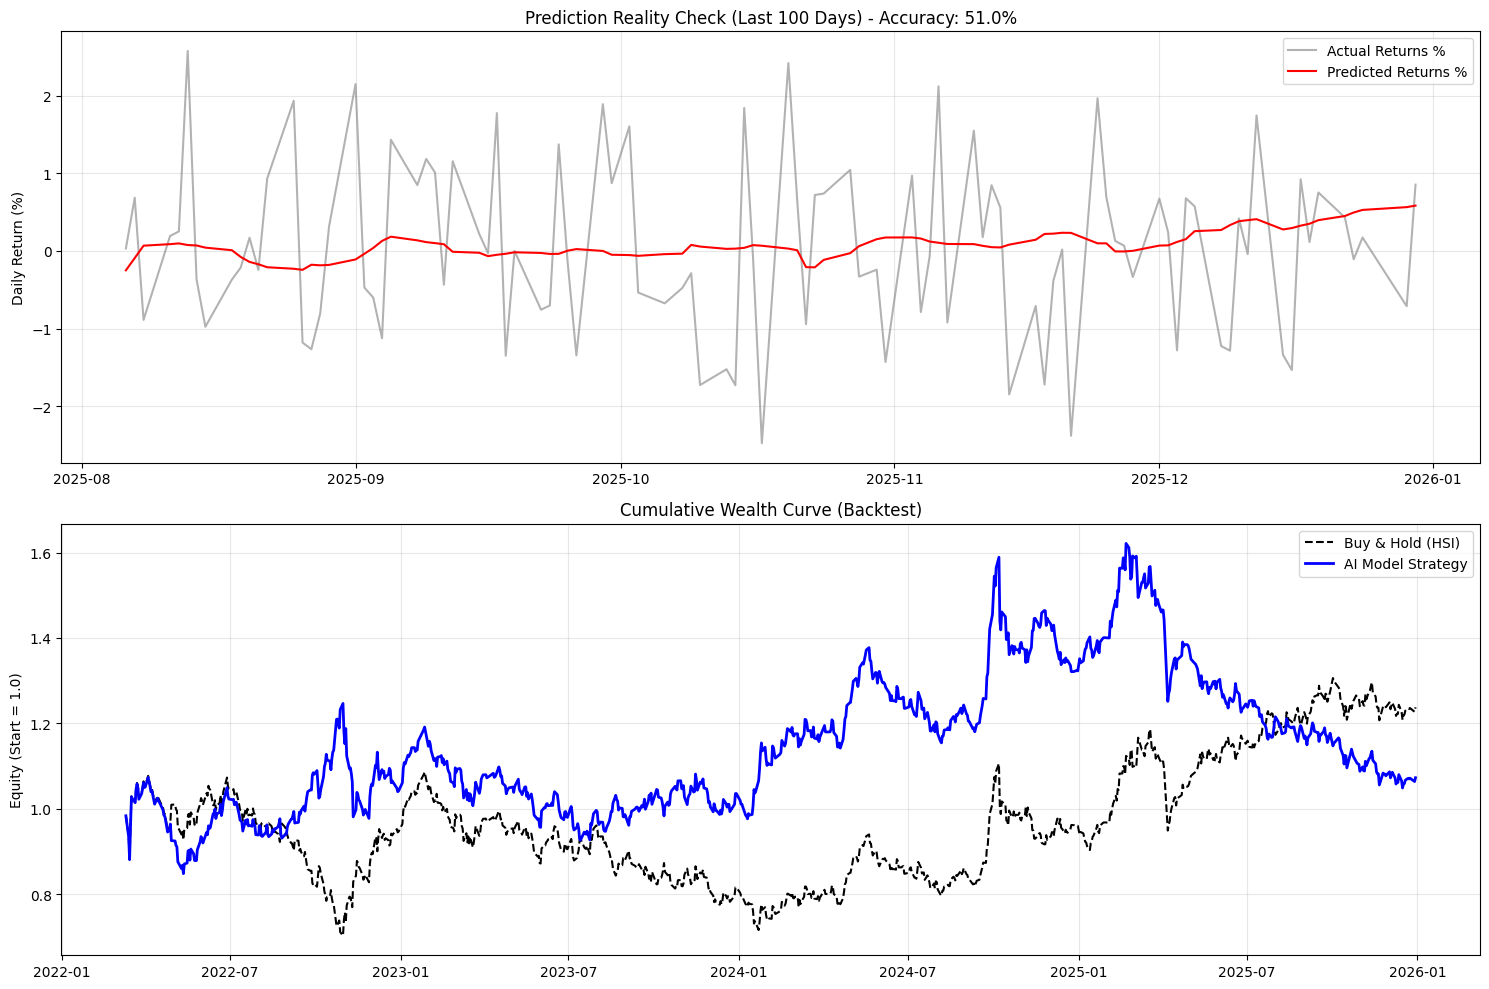


[Verdict / 最终诊断]
⚠️ 模型勉强及格，但可能扣除手续费后不赚钱。需要优化特征。


In [13]:
# ============================================================
# STEP 4: VISUALIZATION & REALITY CHECK
# ============================================================
import matplotlib.pyplot as plt

print("\n[STEP 4] Reality Check: Visualizing & Backtesting...")

# 1. 反归一化 (Inverse Transform)
# 这一步非常关键！我们要把模型输出的 "0.5, -1.2" 这种标准值
# 还原成人类能看懂的 "涨幅 1.5%", "跌幅 -2.0%"
actual_returns = scaler_target.inverse_transform(y_test).flatten()
predicted_returns = scaler_target.inverse_transform(test_pred).flatten()

# 2. 计算方向准确率 (Directional Accuracy)
# 只要方向对(同为正或同为负)，就是赢
# 注意：实际为0的情况要处理，这里简化处理
hits = np.sign(actual_returns) == np.sign(predicted_returns)
accuracy = np.mean(hits) * 100

print("\n" + "="*40)
print("TRADING PERFORMANCE METRICS")
print("="*40)
print(f"1. Directional Accuracy: {accuracy:.2f}%")
print(f"   (> 50% is baseline, > 55% is good)")

# 3. 简单的策略回测 (Simple Vectorized Backtest)
# 策略：预测涨就买(持有1天)，预测跌就空(持有1天)
# 交易成本：假设每次万分之2 (0.02%)
cost_per_trade = 0.0002
signals = np.sign(predicted_returns)

# 策略收益 = 信号 * 实际涨跌 - 成本
strategy_returns = signals * (actual_returns / 100) - cost_per_trade
# 基准收益 (买入持有)
benchmark_returns = actual_returns / 100

# 计算累计收益曲线
equity_strategy = np.cumprod(1 + strategy_returns)
equity_benchmark = np.cumprod(1 + benchmark_returns)

print(f"2. Strategy Total Return: {(equity_strategy[-1] - 1)*100:.2f}%")
print(f"3. Buy & Hold Return:     {(equity_benchmark[-1] - 1)*100:.2f}%")

# 4. 绘图分析
plt.figure(figsize=(15, 10))

# 子图 1: 预测 vs 真实 (局部放大看细节)
plt.subplot(2, 1, 1)
zoom_slice = slice(-100, None) # 只看最后100天，看得更清楚
plt.plot(test_dates[zoom_slice], actual_returns[zoom_slice], label='Actual Returns %', color='grey', alpha=0.6)
plt.plot(test_dates[zoom_slice], predicted_returns[zoom_slice], label='Predicted Returns %', color='red', linewidth=1.5)
plt.title(f'Prediction Reality Check (Last 100 Days) - Accuracy: {accuracy:.1f}%')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 2: 累计收益曲线 (赚没赚钱?)
plt.subplot(2, 1, 2)
plt.plot(test_dates, equity_benchmark, label='Buy & Hold (HSI)', color='black', linestyle='--')
plt.plot(test_dates, equity_strategy, label='AI Model Strategy', color='blue', linewidth=2)
plt.title('Cumulative Wealth Curve (Backtest)')
plt.ylabel('Equity (Start = 1.0)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 解释 R2 到底行不行
print("\n[Verdict / 最终诊断]")
if accuracy > 52 and equity_strategy[-1] > equity_benchmark[-1]:
    print("✅ 模型具备实战潜力！")
elif accuracy > 50:
    print("⚠️ 模型勉强及格，但可能扣除手续费后不赚钱。需要优化特征。")
else:
    print("❌ 模型目前不可用 (甚至不如抛硬币)")

In [14]:
# ============================================================
# STEP 4: ANALYZE PATTERN ATTENTION
# ============================================================
import numpy as np

# Get pattern names
pattern_names = patterns_df.columns.tolist()

# Average pattern attention across all test samples
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)

print("\n" + "=" * 60)
print("PATTERN IMPORTANCE RANKING")
print("=" * 60)
print("\nWhich trading patterns does the model focus on?\n")

# Sort by importance
pattern_importance = list(zip(pattern_names, avg_pattern_attention))
pattern_importance.sort(key=lambda x: x[1], reverse=True)

for i, (pattern, weight) in enumerate(pattern_importance, 1):
    bar = '█' * int(weight * 200)
    print(f"{i:2d}. {pattern:<25} {weight:.4f} {bar}")

# Show specific prediction examples
print("\n" + "=" * 60)
print("EXAMPLE PREDICTIONS WITH PATTERN ATTENTION")
print("=" * 60)

y_test_flat = y_test.flatten()
test_pred_flat = test_pred.flatten()

# 随机选择 5 个样本
sample_indices = np.random.choice(len(test_pred_flat), 5, replace=False)

for idx in sample_indices:
    if idx < len(test_dates):
        date = test_dates[idx]

        actual_val = float(y_test_flat[idx])
        predicted_val = float(test_pred_flat[idx])

        print(f"\n{'='*60}")
        print(f"Date: {date.date()}")
        print(f"Actual Return: {actual_val:.4f}% | Predicted Return: {predicted_val:.4f}%")
        print(f"\nTop 5 Patterns the Model Focused On:")

        # Get pattern attention for this sample
        sample_pattern_attn = test_pattern_attn[idx]

        # Sort patterns by attention
        sample_importance = list(zip(pattern_names, sample_pattern_attn))
        sample_importance.sort(key=lambda x: x[1], reverse=True)

        for i, (pattern, weight) in enumerate(sample_importance[:5], 1):
            pct = weight * 100
            bar = '█' * int(weight * 100)
            print(f"  {i}. {pattern:<25} {pct:>5.1f}% {bar}")


PATTERN IMPORTANCE RANKING

Which trading patterns does the model focus on?

 1. Price_Z_Score_60          0.0317 ██████
 2. Quarter_3                 0.0274 █████
 3. MACD_Bearish_Cross        0.0248 ████
 4. ADOSC                     0.0219 ████
 5. MOM_Quarter               0.0215 ████
 6. BB_Touch_Lower            0.0194 ███
 7. MA10_MA20_Diff            0.0187 ███
 8. RSI_Oversold              0.0186 ███
 9. SSE_Gap                   0.0184 ███
10. Vol_Trend_Consistency     0.0174 ███
11. Inside_Day                0.0171 ███
12. Trend_Macro_200d          0.0169 ███
13. Drawdown_Bounce           0.0167 ███
14. BB_Width_Compressed       0.0159 ███
15. Vol_Dry_Up                0.0159 ███
16. DXY_Trend                 0.0159 ███
17. Beta_Coeff                0.0149 ██
18. 2Day_Uptrend              0.0146 ██
19. Vol_Rel_20                0.0145 ██
20. Vol_Rel_5                 0.0143 ██
21. KDJ_D                     0.0136 ██
22. RSI_Velocity              0.0134 ██
23. BB_Touch_Upper

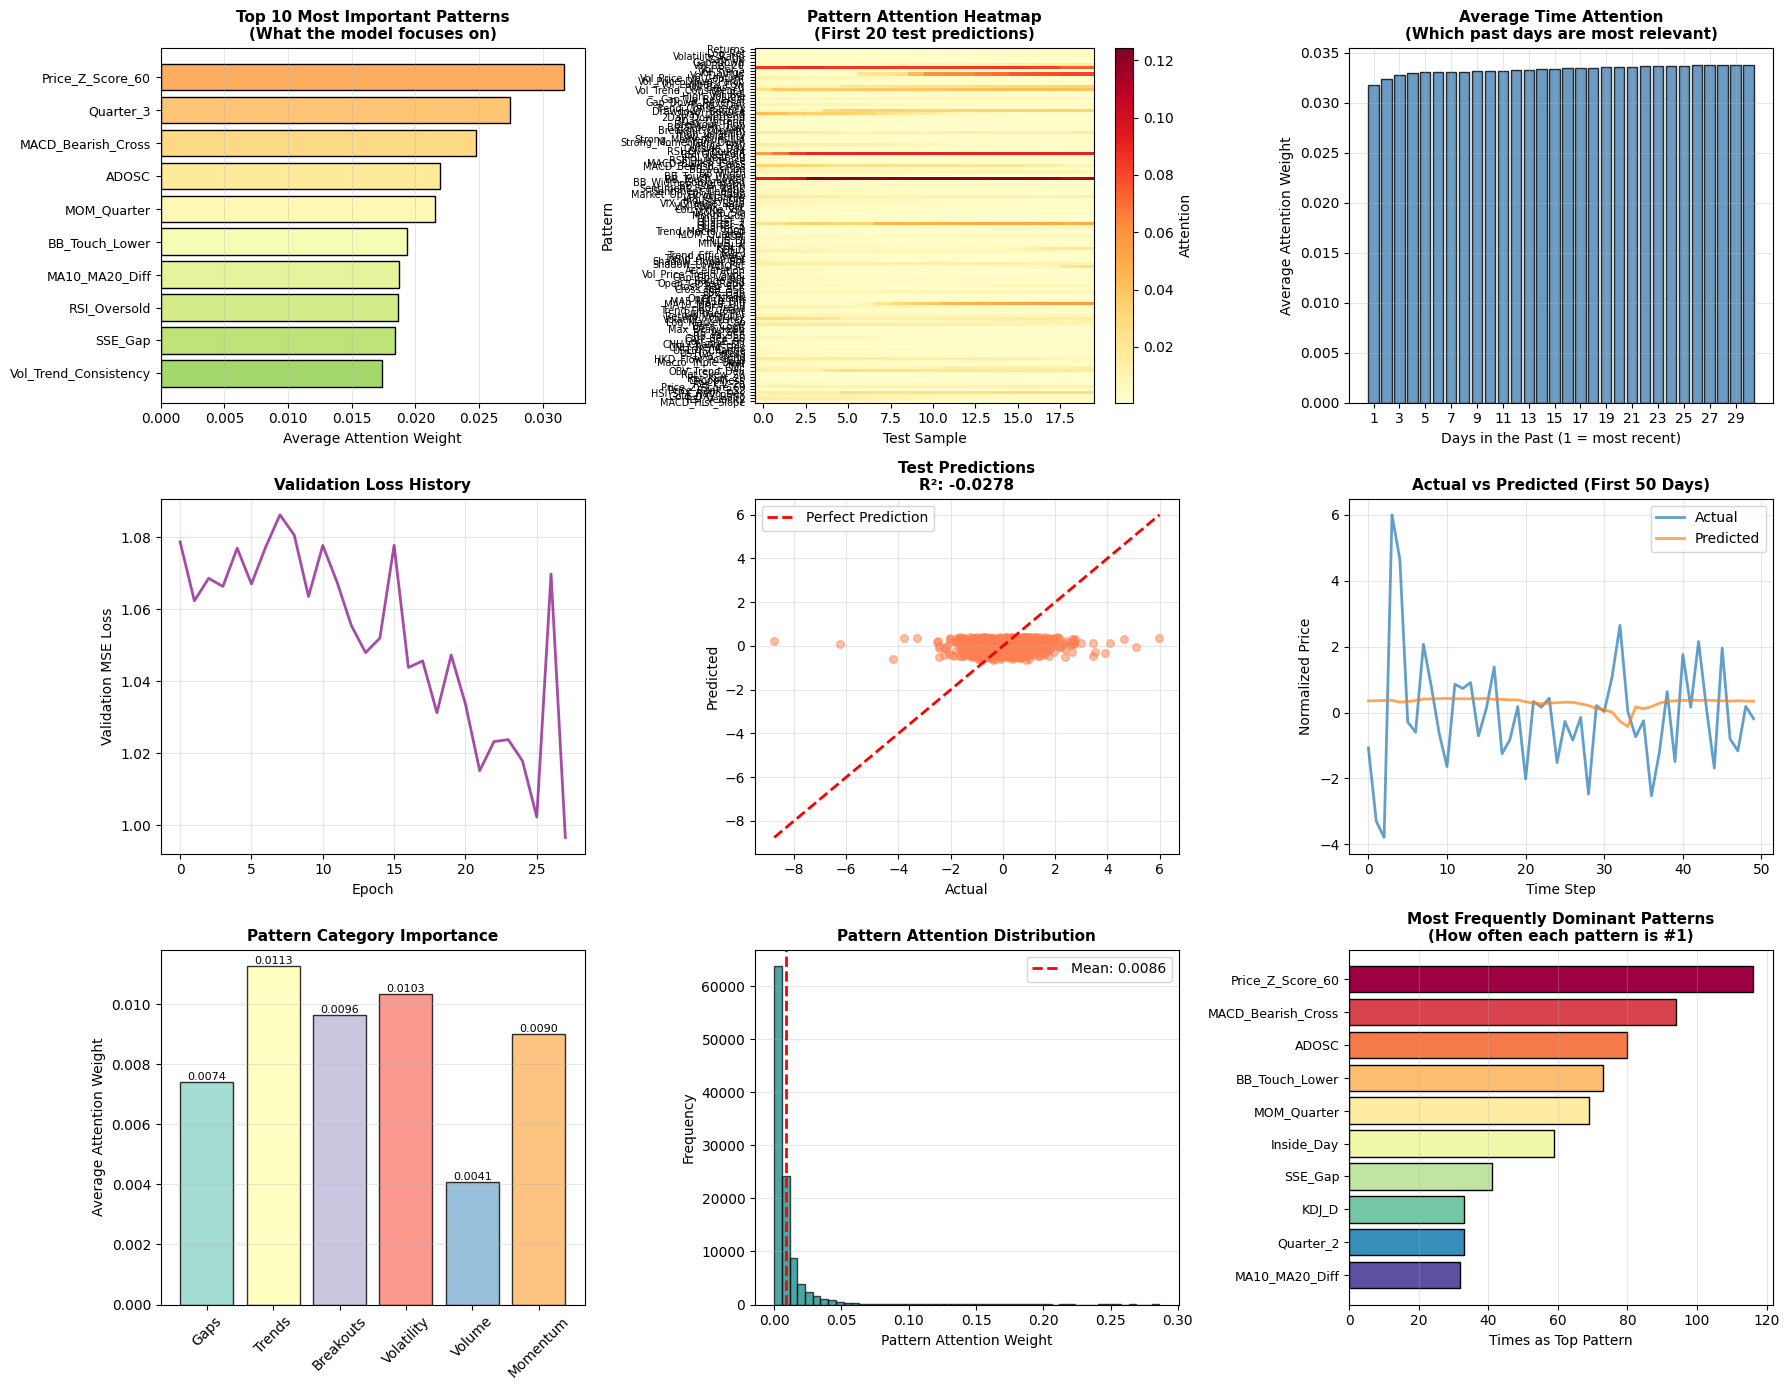


PATTERN CATEGORY ANALYSIS
Trends          0.0113
Volatility      0.0103
Breakouts       0.0096
Momentum        0.0090
Gaps            0.0074
Volume          0.0041


In [15]:
# ============================================================
# STEP 5: CREATE COMPREHENSIVE VISUALIZATIONS
# ============================================================


y_test_patterns = y_test.flatten()
test_pred_flat = test_pred.flatten()
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)
pattern_importance = list(zip(pattern_names, avg_pattern_attention))
pattern_importance.sort(key=lambda x: x[1], reverse=True)
losses = [{'val_loss_mse': loss} for loss in train_losses]

fig = plt.figure(figsize=(18, 14))

# 1. Pattern Importance Bar Chart
ax1 = plt.subplot(3, 3, 1)
top_10_patterns = pattern_importance[:10]
patterns_top10 = [p[0] for p in top_10_patterns]
weights_top10 = [p[1] for p in top_10_patterns]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, 10))
bars = ax1.barh(range(len(patterns_top10)), weights_top10, color=colors, edgecolor='black')
ax1.set_yticks(range(len(patterns_top10)))
ax1.set_yticklabels(patterns_top10, fontsize=9)
ax1.set_xlabel('Average Attention Weight', fontsize=10)
ax1.set_title('Top 10 Most Important Patterns\n(What the model focuses on)',
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Pattern Attention Heatmap (sample predictions)
ax2 = plt.subplot(3, 3, 2)
sample_size = 20
sample_attn = test_pattern_attn[:sample_size]

im = ax2.imshow(sample_attn.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Test Sample', fontsize=10)
ax2.set_ylabel('Pattern', fontsize=10)
ax2.set_yticks(range(len(pattern_names)))
ax2.set_yticklabels(pattern_names, fontsize=7)
ax2.set_title('Pattern Attention Heatmap\n(First 20 test predictions)',
              fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Attention')

# 3. Time Attention Distribution
ax3 = plt.subplot(3, 3, 3)
avg_time_attention = np.mean(test_time_attn, axis=0)
days_back = np.arange(1, len(avg_time_attention) + 1) # 1-indexed for clarity in plotting

ax3.bar(days_back, avg_time_attention, alpha=0.8, color='steelblue', edgecolor='black')
ax3.set_xlabel('Days in the Past (1 = most recent)', fontsize=10)
ax3.set_ylabel('Average Attention Weight', fontsize=10)
ax3.set_title('Average Time Attention\n(Which past days are most relevant)',
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(days_back[::2]) # Show fewer x-ticks for readability

# 4. Training Loss
ax4 = plt.subplot(3, 3, 4)
val_losses = [l['val_loss_mse'] for l in losses] # Extract validation loss
ax4.plot(val_losses, linewidth=2, color='purple', alpha=0.7)
ax4.set_xlabel('Epoch', fontsize=10)
ax4.set_ylabel('Validation MSE Loss', fontsize=10) # Updated label
ax4.set_title('Validation Loss History', fontsize=11, fontweight='bold') # Updated title
ax4.grid(True, alpha=0.3)

# 5. Predictions vs Actual
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(y_test_patterns, test_pred, alpha=0.5, s=30, color='coral')
ax5.plot([y_test_patterns.min(), y_test_patterns.max()], [y_test_patterns.min(), y_test_patterns.max()],
         'r--', lw=2, label='Perfect Prediction')
ax5.set_xlabel('Actual', fontsize=10)
ax5.set_ylabel('Predicted', fontsize=10)
ax5.set_title(f'Test Predictions\nR²: {test_r2:.4f}', fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Time Series Predictions
ax6 = plt.subplot(3, 3, 6)
plot_range = slice(0, 50)
ax6.plot(y_test_patterns[plot_range], label='Actual', linewidth=2, alpha=0.7)
ax6.plot(test_pred[plot_range], label='Predicted', linewidth=2, alpha=0.7)
ax6.set_xlabel('Time Step', fontsize=10)
ax6.set_ylabel('Normalized Price', fontsize=10)
ax6.set_title('Actual vs Predicted (First 50 Days)', fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Pattern Category Analysis
ax7 = plt.subplot(3, 3, 7)
# Group patterns by category
categories = {
    'Gaps': ['Gap_Up', 'Gap_Down', 'Gap_Up_Reversal', 'Gap_Down_Reversal'],

    'Trends': ['2Day_Uptrend', '2Day_Downtrend', '3Day_Uptrend', '3Day_Downtrend',
               'Trend_Score_3D', 'MACD_Bullish_Cross', 'MACD_Bearish_Cross'],

    'Breakouts': ['Breakout_High', 'Breakdown_Low', 'Drawdown_Bounce',
                  'Dist_from_High', 'Dist_from_Low'],

    'Volatility': ['High_Volatility', 'Low_Volatility', 'Inside_Day', 'Outside_Day',
                   'Volatility_ATR_Ratio', 'BB_Width_Compressed'],

    'Volume': ['High_Volume', 'Low_Volume', 'Volume_Change', 'Vol_Rel'],

    'Momentum': ['Strong_Momentum_Up', 'Strong_Momentum_Down', 'Returns', 'Log_Ret',
                 'RSI_Overbought', 'RSI_Oversold', 'RSI_Near_50', 'RSI_Score',
                 'BB_Touch_Upper', 'BB_Touch_Lower', 'BB_Z_Score']
}

category_weights = {}
for cat, patterns in categories.items():
    weights = [avg_pattern_attention[pattern_names.index(p)] for p in patterns if p in pattern_names]
    category_weights[cat] = np.mean(weights)

cats = list(category_weights.keys())
cat_weights = list(category_weights.values())

colors_cat = plt.cm.Set3(range(len(cats)))
bars = ax7.bar(cats, cat_weights, color=colors_cat, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Average Attention Weight', fontsize=10)
ax7.set_title('Pattern Category Importance', fontsize=11, fontweight='bold')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 8. Attention Distribution
ax8 = plt.subplot(3, 3, 8)
all_pattern_attn = test_pattern_attn.flatten()
ax8.hist(all_pattern_attn, bins=50, color='teal', alpha=0.7, edgecolor='black')
ax8.axvline(np.mean(all_pattern_attn), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(all_pattern_attn):.4f}')
ax8.set_xlabel('Pattern Attention Weight', fontsize=10)
ax8.set_ylabel('Frequency', fontsize=10)
ax8.set_title('Pattern Attention Distribution', fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# 9. Top Patterns Over Time
ax9 = plt.subplot(3, 3, 9)
# Track which pattern gets highest attention for each prediction
top_pattern_per_sample = np.argmax(test_pattern_attn, axis=1)
pattern_counts = {}
for pattern_idx in top_pattern_per_sample:
    pattern_name = pattern_names[pattern_idx]
    pattern_counts[pattern_name] = pattern_counts.get(pattern_name, 0) + 1

# Sort and plot top 10
sorted_counts = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_patterns = [p[0] for p in sorted_counts]
top_counts = [p[1] for p in sorted_counts]

colors_top = plt.cm.Spectral(np.linspace(0, 1, len(top_patterns)))
bars = ax9.barh(range(len(top_patterns)), top_counts, color=colors_top, edgecolor='black')
ax9.set_yticks(range(len(top_patterns)))
ax9.set_yticklabels(top_patterns, fontsize=9)
ax9.set_xlabel('Times as Top Pattern', fontsize=10)
ax9.set_title('Most Frequently Dominant Patterns\n(How often each pattern is #1)',
              fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')
ax9.invert_yaxis()

plt.tight_layout()
plt.savefig('pattern_attention_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("PATTERN CATEGORY ANALYSIS")
print("=" * 60)
for cat, weight in sorted(category_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{cat:<15} {weight:.4f}")


STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI)
current date: 2025-12-30 00:00:00
Starting simulation from: 2025-12-30
Last Close Price: 25854.60
Starting simulation from: 2025-12-30
Last Close Price: 25854.60

Simulating 15 trading days into the future...

--------------------------------------------------
🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)
--------------------------------------------------
 1. SSE_Gap                   17.25%
 2. MACD_Bearish_Cross         8.60%
 3. Quarter_2                  5.38%
 4. Beta_Coeff                 4.90%
 5. KDJ_K                      4.73%
 6. Shadow_Lower_Pct           3.80%
 7. Sentiment_Change           2.89%
 8. MACD_Hist_Slope            1.74%
 9. Open_Norm                  1.59%
10. Corr_SSE_60                1.46%

Time Attention Peak: Index 12 (0=Oldest, 19=Yesterday)
--------------------------------------------------

Day 5/15: Predicted +0.28%, Price 26179.06
Day 10/15: Predicted +0.11%, Price 26327.80
Day 15/15: Predicted +0.2

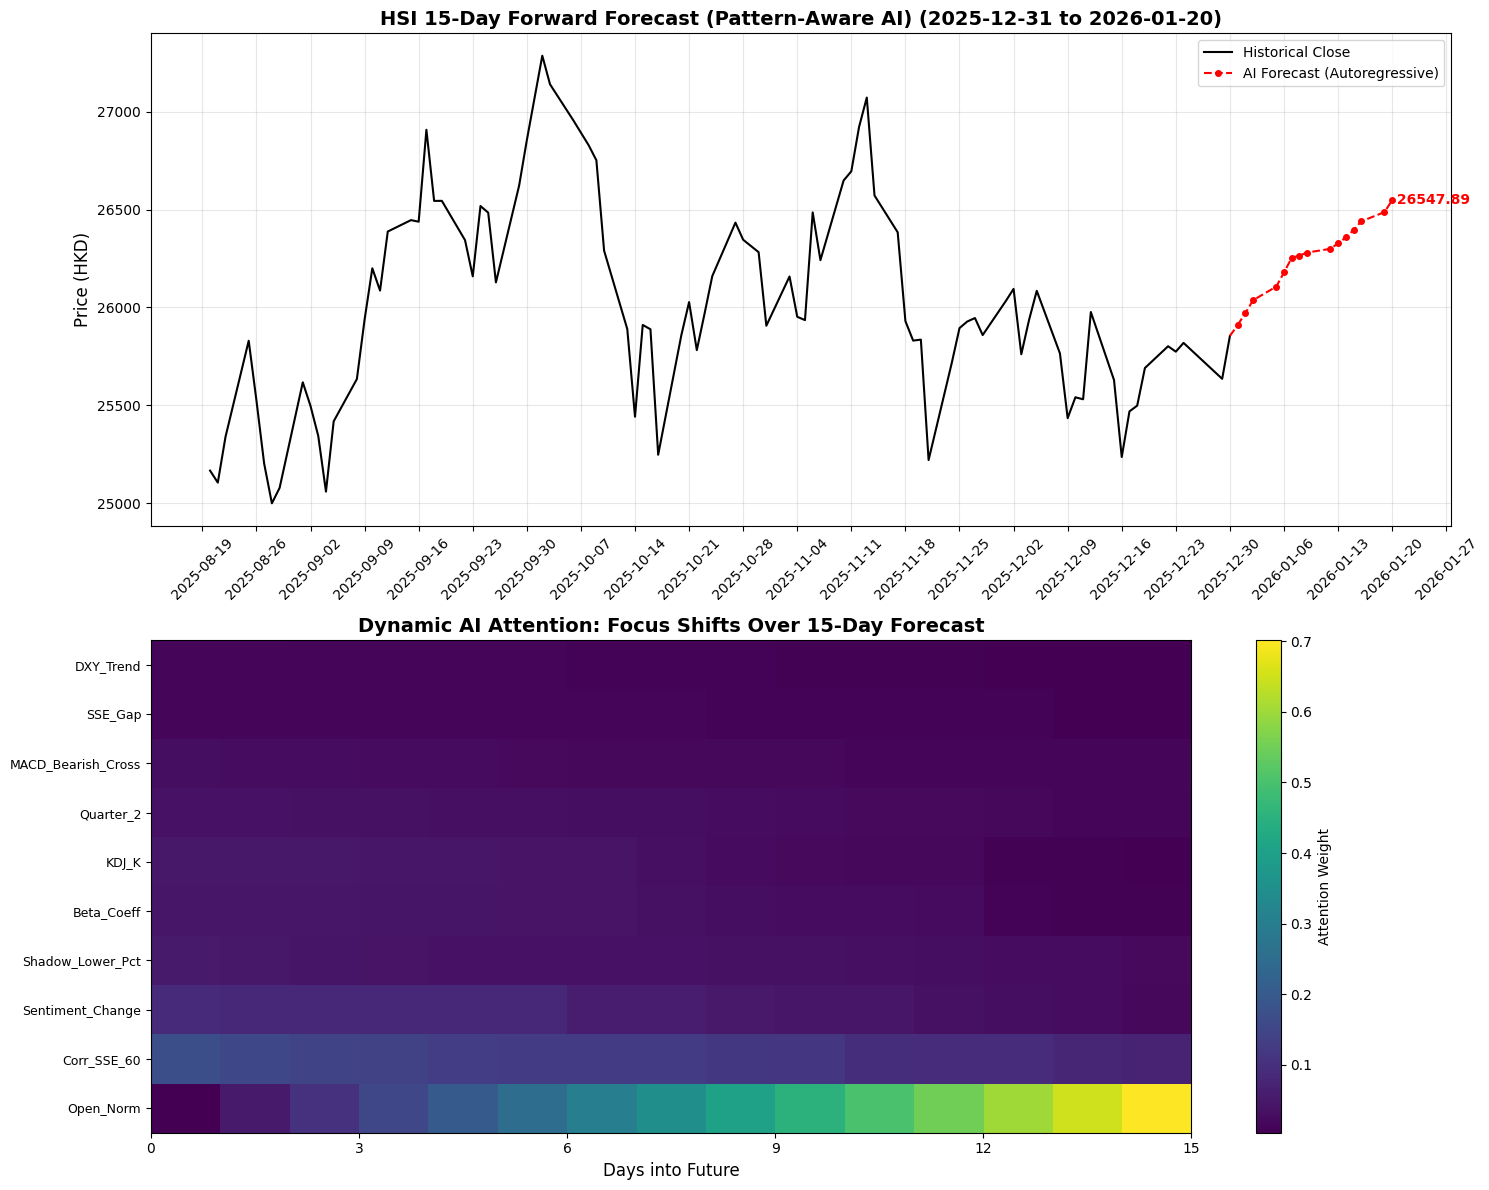


FORECAST DATA TABLE
      Date  Forecast_Price (HKD)  Predicted_Change (%)
2025-12-31              25909.91                  0.21
2026-01-01              25971.03                  0.45
2026-01-02              26037.02                  0.71
2026-01-05              26106.63                  0.97
2026-01-06              26179.06                  1.25
2026-01-07              26253.74                  1.54
2026-01-08              26265.45                  1.59
2026-01-09              26280.86                  1.65
2026-01-12              26299.78                  1.72
2026-01-13              26327.80                  1.83
2026-01-14              26357.96                  1.95
2026-01-15              26395.75                  2.09
2026-01-16              26440.25                  2.27
2026-01-19              26487.47                  2.45
2026-01-20              26547.89                  2.68
Final Forecast Price: 26547.89 HKD
Total Predicted Change: +2.68%


In [10]:
# ============================================================
# STEP 7: AUTOREGRESSIVE FORECAST (WITH TOMORROW'S ATTENTION)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import BDay

print("\n" + "=" * 70)
print("STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI)")
print("=" * 70)

# -------------------------- 补充核心依赖（纯pandas，无额外库） --------------------------
# 1. 替代pandas_market_calendars：用BDay+手动过滤生成交易日（兼容香港股市周末休市）
def get_next_trading_day(current_date):
    """
    生成下一个交易日（跳过周末，用BDay实现，纯pandas原生）
    current_date: 当前日期（datetime类型）
    返回：下一个交易日（datetime类型）
    """
    next_day = current_date + BDay(1)
    return next_day

# -------------------------- 核心预测逻辑（修复后） --------------------------
# 1. 配置参数
FORECAST_DAYS = 15
SEQUENCE_LENGTH = 20

# 2. 准备初始数据（确保索引为datetime类型）
history_df = df.copy()
current_date =history_df.index[-1]
print("current date:",current_date)
last_close_price = history_df['Close'].iloc[-1]

if not pd.api.types.is_datetime64_any_dtype(history_df.index):
    history_df.index = pd.to_datetime(history_df.index)  # 强制转换为datetime索引
current_date = history_df.index[-1]
last_close_price = history_df['Close'].iloc[-1]

# 获取特征名称列表
feature_names = detect_trading_patterns(history_df).columns.tolist()
assert len(feature_names) == 116, f"特征数量应为116，实际为{len(feature_names)}（与Step 2不一致）"

print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")

# 存储推演结果
future_dates = []
future_prices = []
future_attentions = []

feature_names = patterns_df.columns.tolist()
print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")

# 存储推演结果
future_dates = []
future_prices = []
future_attentions = []

# 确保模型处于评估模式
model.eval()

print(f"\nSimulating {FORECAST_DAYS} trading days into the future...")

# ---------------------------------------------------------
# AUTOREGRESSIVE LOOP (自回归循环)
# ---------------------------------------------------------
for i in range(FORECAST_DAYS):
    # A. 动态特征工程，计算新的pattern
    current_patterns = detect_trading_patterns(history_df)

    # B. 准备模型输入（确保序列长度和归一化正确）
    if len(current_patterns) < SEQUENCE_LENGTH:
        raise ValueError(f"历史数据不足{SEQUENCE_LENGTH}天，无法生成输入序列")
    last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
    last_seq_scaled = scaler.transform(last_seq_raw)
    input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

    # C. 模型预测（限制收益范围，避免价格发散）
    with torch.no_grad():
        pred_ret_tensor, p_attn, t_attn = model(input_tensor)
        pred_ret_pct = pred_ret_tensor.item()
        # 限制预测收益在[-5, 5]%之间（避免极端值导致价格不合理）
        pred_ret_pct = np.clip(pred_ret_pct, -5.0, 5.0)
        avg_p_attn = p_attn.mean(dim=1).cpu().numpy().flatten()

        # 展示第一天(明天)的关注点
        if i == 0:
            print("\n" + "-"*50)
            print("🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)")
            print("-"*50)

            # 排序并打印Top 10
            day1_importance = list(zip(feature_names, avg_p_attn))
            day1_importance.sort(key=lambda x: x[1], reverse=True)

            for rank, (name, weight) in enumerate(day1_importance[:10], 1):
                print(f"{rank:2d}. {name:<25} {weight*100:5.2f}%")

            # 打印时间关注点
            avg_t_attn = t_attn.squeeze().cpu().numpy()
            peak_day = np.argmax(avg_t_attn)
            print(f"\nTime Attention Peak: Index {peak_day} (0=Oldest, {SEQUENCE_LENGTH-1}=Yesterday)")
            print("-"*50 + "\n")

    # D. 还原价
    new_price = last_close_price * (1 + pred_ret_pct / 100)
    new_price = max(new_price, 0.01)

    # E. 构造新的一行数据（完善所有必要列）
    next_date = get_next_trading_day(current_date)

    # 计算辅助指标（用于后续特征生成）
    recent_window = history_df.iloc[-20:]

    recent_atr = recent_window[['High', 'Low', 'Close']].apply(
        lambda x: max(x.iloc[0]-x.iloc[1], abs(x.iloc[0]-x.iloc[2]), abs(x.iloc[1]-x.iloc[2])),
        axis=1
    ).mean()
    recent_atr = recent_atr if not np.isnan(recent_atr) and recent_atr > 0 else last_close_price * 0.01
    recent_vol = recent_window['Volume'].mean() if not np.isnan(recent_window['Volume'].mean()) else 1e6

    # 构造新行
    new_row = pd.DataFrame({
        'Open': [new_price],
        'High': [new_price + recent_atr * 0.5],
        'Low': [new_price - recent_atr * 0.5],
        'Close': [new_price],
        'Volume': [recent_vol],
        'Log_Ret': [np.log(new_price / last_close_price)]
    }, index=[next_date])

    for col in history_df.columns:
        if col not in new_row.columns and col != 'Target':
            new_row[col] = 0.0

    # F. 更新状态
    history_df = pd.concat([history_df, new_row], ignore_index=False)
    current_date = next_date
    last_close_price = new_price

    # 记录结果
    future_dates.append(next_date)
    future_prices.append(new_price)
    future_attentions.append(avg_p_attn)

    # 打印进度
    if (i+1) % 5 == 0:
        print(f"Day {i+1}/{FORECAST_DAYS}: Predicted {pred_ret_pct:+.2f}%, Price {new_price:.2f}")

# ============================================================
# VISUALIZATION
# ============================================================
print("\n[PLOTTING FORECAST]")

plt.figure(figsize=(15, 12))

# 1. Price Forecast Chart
plt.subplot(2, 1, 1)
recent_history = df.iloc[-90:]
plt.plot(recent_history.index, recent_history['Close'], label='Historical Close', color='black', linewidth=1.5)
plt.plot(future_dates, future_prices, label='AI Forecast (Autoregressive)', color='red', linestyle='--', marker='o', markersize=4, linewidth=1.5)

# 连接历史与预测数据
plt.plot([recent_history.index[-1], future_dates[0]],
         [recent_history['Close'].iloc[-1], future_prices[0]],
         color='red', linestyle='--', linewidth=1.5)

# 添加最终价格标签
plt.text(future_dates[-1], future_prices[-1], f" {future_prices[-1]:.2f}",
         color='red', fontweight='bold', va='center', fontsize=10)

# Get forecast date range from future_dates
forecast_start_date_plot = future_dates[0].strftime('%Y-%m-%d')
forecast_end_date_plot = future_dates[-1].strftime('%Y-%m-%d')
plot_title_suffix = f" ({forecast_start_date_plot} to {forecast_end_date_plot})"

plt.title(f'HSI 15-Day Forward Forecast (Pattern-Aware AI){plot_title_suffix}', fontsize=14, fontweight='bold')
plt.ylabel('Price (HKD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
# 格式化x轴日期
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.xticks(rotation=45)

# 2. Future Attention Heatmap
plt.subplot(2, 1, 2)
attn_matrix = np.array(future_attentions)

# 只显示平均注意力最高的10个特征（避免图表拥挤）
avg_sim_attn = np.mean(attn_matrix, axis=0)
top_idx = np.argsort(avg_sim_attn)[-10:]  # 取Top 10特征的索引
top_names = [feature_names[i] for i in top_idx]
top_matrix = attn_matrix[:, top_idx]

# 绘制热力图
im = plt.imshow(top_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest',
                extent=[0, FORECAST_DAYS, 0, 10])

plt.yticks(np.arange(0.5, 10.5, 1), top_names, fontsize=9)
plt.xlabel('Days into Future', fontsize=12)
plt.title('Dynamic AI Attention: Focus Shifts Over 15-Day Forecast', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Attention Weight')
# x轴刻度与预测天数对应
plt.xticks(range(0, FORECAST_DAYS+1, 3))

plt.tight_layout()
plt.show()

# 3. Output Table（优化格式）
forecast_df = pd.DataFrame({
    'Date': [d.date() for d in future_dates],
    'Forecast_Price (HKD)': [round(p, 2) for p in future_prices],
    'Predicted_Change (%)': [round((p - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100, 2) for p in future_prices]
})

print("\n" + "=" * 60)
print("FORECAST DATA TABLE")
print("=" * 60)
print(forecast_df.to_string(index=False))
print("=" * 60)
print(f"Final Forecast Price: {future_prices[-1]:.2f} HKD")
print(f"Total Predicted Change: {(future_prices[-1] - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100:+.2f}%")



STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
   (Re-)Fetching HSI data for consistency within this step...
   [FIX] Fetching VIX (^HSIL) and external assets...
   Dropped 0 rows due to NaNs or zero volume.
Volume过滤后的最新日期: 2025-12-30
   [Re-initialized] df has 1227 rows.
   [Re-initialized] patterns_df has 1227 rows and 116 features.
   Using Device: cpu
   使用生成的 patterns_df：共 116 个特征
   最新数据日期: 2025-12-30
   总交易天数: 1227

🚀 Running Scenario: [Reserve 1 Month]
   Cutoff Date: 2025-11-28
   训练序列数: 1186 | 验证集天数: 20
   Training model... Done (Final Loss: 0.000274)
   Simulating 65 days (Holdout: 20, Future: 45)...

🚀 Running Scenario: [Reserve 15 Days]
   Cutoff Date: 2025-12-09
   训练序列数: 1193 | 验证集天数: 13
   Training model... Done (Final Loss: 0.000295)
   Simulating 58 days (Holdout: 13, Future: 45)...

🚀 Running Scenario: [All Data]
   Cutoff Date: 2025-12-30
   训练序列数: 1206 | 验证集天数: 0
   Training model... Done (Final Loss: 0.000298)
   Simulating 45 days (Holdout: 0, Future: 45)..

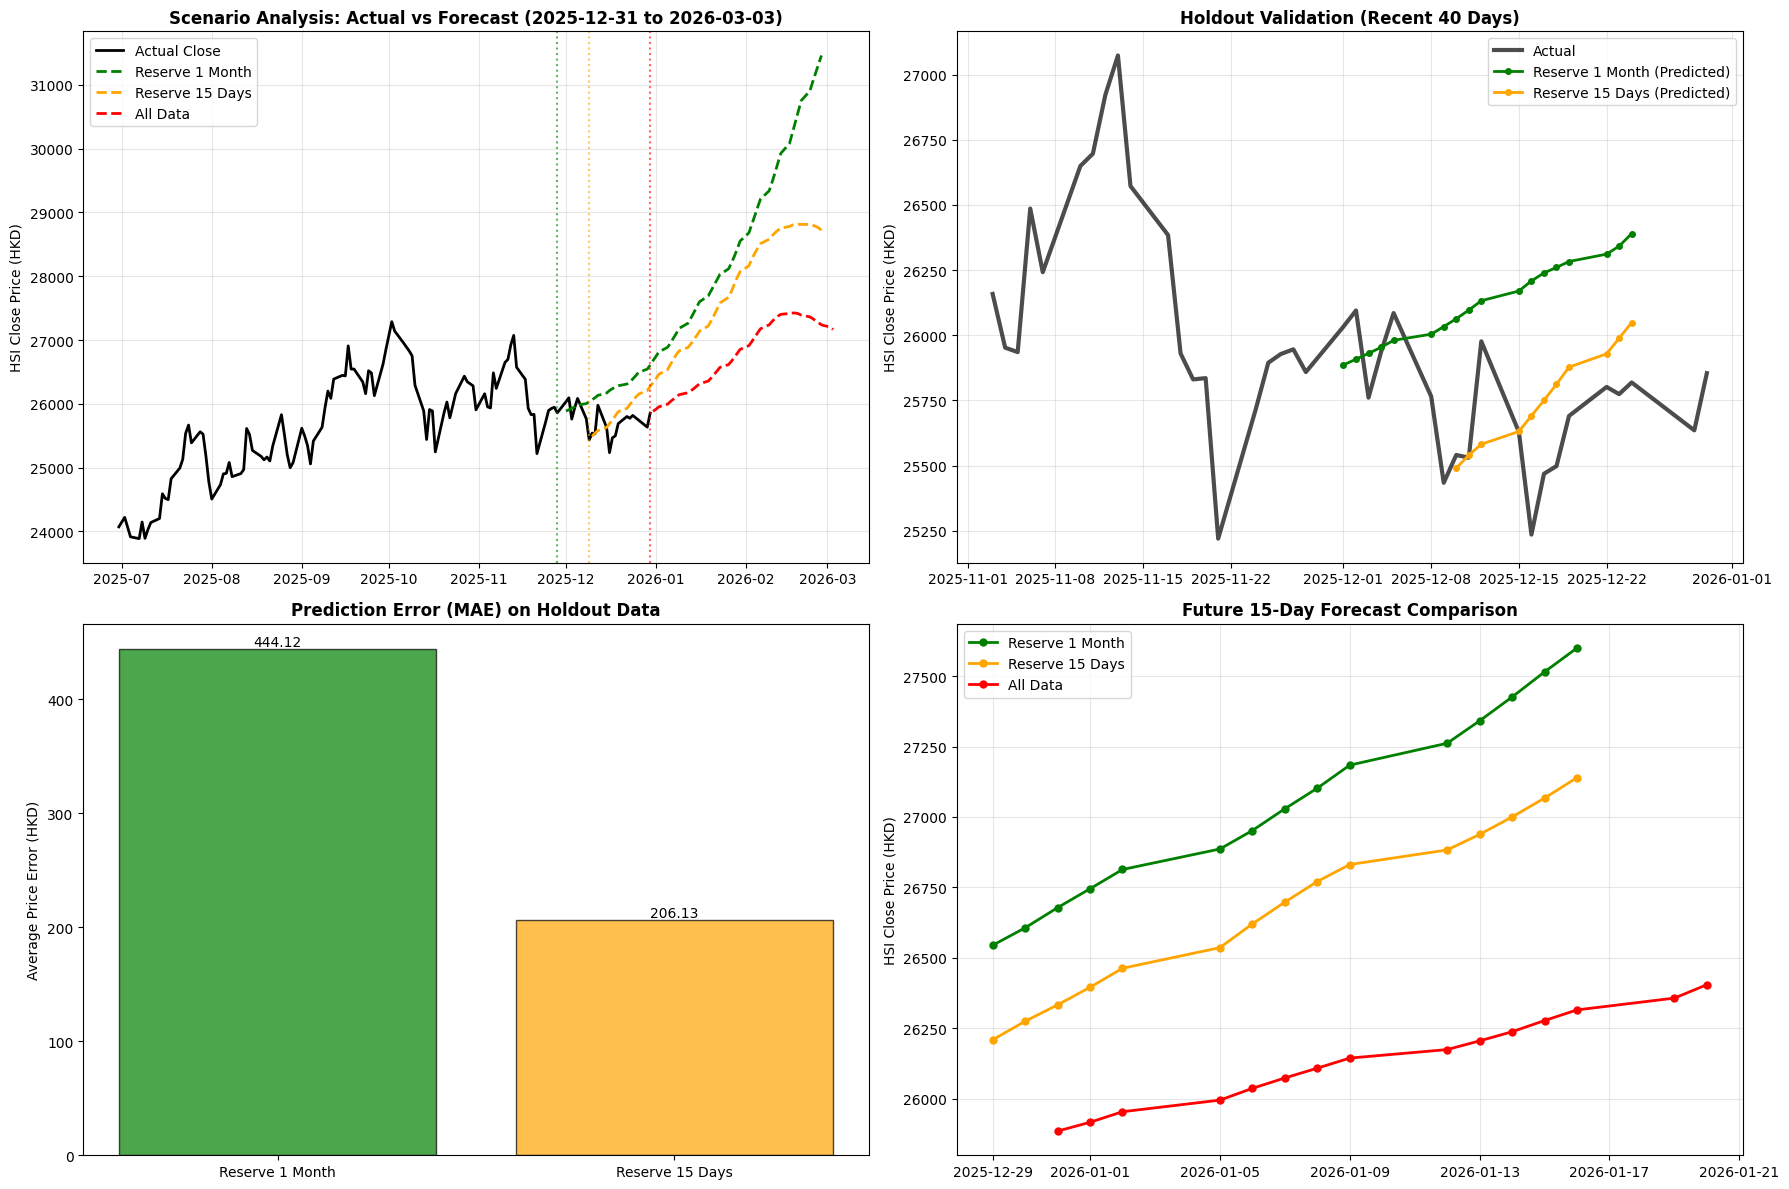


=== SCENARIO BACKTESTING SUMMARY ===

📊 [Reserve 1 Month]
   Training Cutoff: 2025-11-28
   Train Sequences: 1186
   Holdout Days: 20
   Holdout MAE: 444.12 HKD
   Top 10 Important Patterns (Attention Weight):
      1. Open_Close_Ratio                 2.50%
      2. Log_Ret                          1.94%
      3. Month_Sin                        1.89%
      4. BB_Width_Compressed              1.60%
      5. Gap_Down                         1.60%
      6. KDJ_J                            1.57%
      7. Gap_Down_Reversal                1.57%
      8. Acceleration                     1.55%
      9. BB_Touch_Upper                   1.39%
     10. Volatility_Cluster               1.38%
   Time Attention Peak: Day 0 (0=Oldest, 19=Yesterday)

📊 [Reserve 15 Days]
   Training Cutoff: 2025-12-09
   Train Sequences: 1193
   Holdout Days: 13
   Holdout MAE: 206.13 HKD
   Top 10 Important Patterns (Attention Weight):
      1. BB_Width_Compressed              2.61%
      2. Cross_Ret_SPX           

In [16]:
# ============================================================
# STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta

print("\n" + "=" * 70)
print("STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)")
print("=" * 70)

# ====================================================================
# 【修复 1】 数据初始化和外部资产合并 (必须匹配 detect_trading_patterns 的输入)
# ====================================================================
print("   (Re-)Fetching HSI data for consistency within this step...")
ticker = yf.Ticker("^HSI")
end_date = datetime.now() + timedelta(days=1)
start_date = end_date - timedelta(days=5*365) # 使用 5 年数据

# --- 1. 获取 HSI 基础数据 ---
df = ticker.history(start=start_date, end=end_date)

# --- NEW: Check if primary HSI data is empty ---
if df.empty:
    print("   ❌ Error: HSI data for the last 5 years is empty. Attempting a wider fetch (20 years).")
    start_date = end_date - timedelta(days=20*365)
    df = ticker.history(start=start_date, end=end_date)
    if df.empty:
        raise ValueError("Critical Error: HSI data could not be fetched even for 20 years. Cannot proceed.")

df.index = pd.to_datetime(df.index).tz_localize(None)
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# --- 2. 获取 VIX (^HSIL) 数据 ---
print("   [FIX] Fetching VIX (^HSIL) and external assets...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)
# Ensure vix_df index is tz-naive before joining
vix_df.index = pd.to_datetime(vix_df.index).tz_localize(None)
if not vix_df.empty:
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
else:
    print("      ⚠️ Warning: ^HSIL data is empty. Using fallback value 20.0.")
    df['VIX_Close'] = 20.0 # Fallback if VIX data is entirely missing

# --- 3. 获取其他外部资产数据 ---
tickers_dict = {
    'SPX_Close': '^GSPC', 'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F', 'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X', 'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F'
}
for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        # Ensure ext_df index is tz-naive before joining
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if not ext_df.empty:
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
        else:
            print(f"      ⚠️ Warning: {col_name} data is empty. Filling with NaN to be handled by later fillna.")
            df[col_name] = np.nan # Add as NaN if empty, will be filled next
    except Exception as e:
        print(f"      ❌ Error fetching {ticker_symbol}: {e}. Filling with NaN.")
        df[col_name] = np.nan

# --- 4. 最终清洗和填充 ---
external_cols = list(tickers_dict.keys()) + ['VIX_Close']

# Use ffill, then a rolling mean, then a final static fill for any remaining NaNs
df[external_cols] = df[external_cols].ffill()
# Calculate rolling mean BEFORE general fillna, on potentially existing data
for col in external_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].rolling(30, min_periods=1).mean())
# Final fill for any remaining NaNs, e.g., if first 30 days are NaN or if the rolling mean is NaN
# Use the column's mean as a last resort, but only for columns that exist
for col in external_cols:
    if col in df.columns and df[col].isnull().any():
        col_mean = df[col].mean()
        if not np.isnan(col_mean):
            df[col] = df[col].fillna(col_mean)
        else:
            # If even the mean is NaN (e.g., column is all NaNs), fill with a sensible default like 0 or 1.0
            # For prices/indices, 1.0 might be more appropriate than 0 to avoid division by zero later.
            df[col] = df[col].fillna(1.0) # Fallback to 1.0 for price-like data if all else fails


# Recalculate external asset returns, ensuring no NaNs from empty data after processing
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

# Critical step: filter out rows with any NaNs *only after* all attempts to fill have been made.
# Also ensure there's still data after filtering.
original_df_rows = len(df)
df = df.dropna(subset=['Close'] + external_cols)
if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after dropping rows with NaNs in essential columns. Data too sparse to proceed.")
print(f"   Dropped {original_df_rows - len(df)} rows due to NaNs or zero volume.")

df = df[
    (df['Volume'] > 0) |  # 非当日：Volume必须>0
    (df.index.date == datetime.now().date())  # 当日：允许Volume=0
]
df.loc[df.index.date == datetime.now().date(), 'Volume'] = df.loc[df.index.date == datetime.now().date(), 'Volume'].replace(
    0, df['Volume'].iloc[-2]  # 取倒数第二行的Volume（12.16的有效值）
)
print(f"Volume过滤后的最新日期: {df.index[-1].date()}")

if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after filtering for Volume > 0. No valid trading days.")

if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

# ====================================================================
# 【修复 2】 重新生成 patterns_df
# ====================================================================

if 'detect_trading_patterns' not in globals():
    raise NameError("The 'detect_trading_patterns' function is not defined. Please ensure previous steps defining it have been executed.")


patterns_df = detect_trading_patterns(df.copy()) # Generate patterns_df from the fresh df

# --- NEW: Check if patterns_df is empty ---
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df is empty after feature detection. Cannot proceed.")

# Ensure patterns_df and df align. If patterns_df lost some rows (e.g. due to internal calculations resulting in NaN),
# then df should also be adjusted.
original_patterns_rows = len(patterns_df)
patterns_df = patterns_df.dropna() # Ensure no NaNs in patterns_df features
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df became empty after dropping rows with NaNs. Features too sparse to proceed.")

if original_patterns_rows != len(patterns_df):
    print(f"   Dropped {original_patterns_rows - len(patterns_df)} rows from patterns_df due to internal NaNs.")

df = df.loc[patterns_df.index] # Align df to the cleaned patterns_df
if df.empty:
    raise ValueError("Critical Error: df became empty after aligning with patterns_df. Data too sparse.")

print(f"   [Re-initialized] df has {len(df)} rows.")
print(f"   [Re-initialized] patterns_df has {len(patterns_df)} rows and {patterns_df.shape[1]} features.")

# ===================== 关键配置 =====================
# ... (模型定义和配置保持不变) ...
# 1. 定义设备（CPU/GPU自动检测）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

# 2. 复用 patterns_df（现在已确保与 df 对齐）
print(f"   使用生成的 patterns_df：共 {patterns_df.shape[1]} 个特征")

# 3. 配置参数（优化训练稳定性）
lstm_sequence_length = 20
forecast_horizon_days = 45
comparison_horizon = 15
SCENARIO_EPOCHS = 50  # 足够训练轮数
LEARNING_RATE = 0.0005  # 低学习率避免震荡
WEIGHT_DECAY = 1e-5  # 权重衰减防过拟合

# 4. 获取基础数据（现在已确保是最新的df）
latest_date = df.index[-1]
print(f"   最新数据日期: {latest_date.date()}")
print(f"   总交易天数: {len(df)}")

# =====================  PatternAwareLSTM 模型   =====================
# ... (PatternAwareLSTM 类定义保持不变) ...
class PatternAwareLSTM(nn.Module):
    def __init__(self, num_patterns, hidden_size=64, num_layers=2, dropout=0.2):
        super(PatternAwareLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_patterns = num_patterns

        # 模式注意力层
        self.pattern_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_patterns),
            nn.Softmax(dim=-1)
        )

        # 时间注意力层
        self.time_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)  # 对时间步归一化
        )

        # 特征投影层（适配特征维度到LSTM输入）
        self.feature_projection = nn.Linear(num_patterns, hidden_size)

        # LSTM 层
        self.lstm = nn.LSTM(
            input_size=num_patterns,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # 输出层（预测收益率，限制范围）
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Tanh()  # 输出[-1,1]，对应±100%收益率
        )

        # 权重初始化（避免训练不稳定）
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # x shape: (batch_size, seq_len, num_patterns)
        batch_size, seq_len, num_patterns = x.shape

        # 1. 特征投影（便于注意力计算）
        x_proj = self.feature_projection(x)  # (batch, seq, hidden_size)

        # 2. 模式注意力（核心修复：权重分散到所有特征）
        p_attn = self.pattern_attention(x_proj)  # (batch, seq, num_patterns)
        p_attn = p_attn / (p_attn.sum(dim=-1, keepdim=True) + 1e-8)  # 确保归一化
        x_p_attended = x * p_attn  # 特征加权

        # 3. LSTM 特征提取
        lstm_out, (hidden, cell) = self.lstm(x_p_attended)  # (batch, seq, hidden_size)

        # 4. 时间注意力
        t_attn = self.time_attention(lstm_out)  # (batch, seq, 1)
        t_attn = t_attn / (t_attn.sum(dim=1, keepdim=True) + 1e-8)
        x_t_attended = lstm_out * t_attn
        context = x_t_attended.sum(dim=1)  # (batch, hidden_size)

        # 5. 预测输出（缩放至合理收益率范围：±10%）
        out = self.fc(context) * 0.1

        return out, p_attn, t_attn

# ===================== 场景分析函数 =====================
def run_scenario_analysis(train_cutoff_date, label):

    print(f"\n🚀 Running Scenario: [{label}]")
    print(f"   Cutoff Date: {train_cutoff_date.date()}")

    # -----------------------------------------------------
    # 1. 数据切片
    # -----------------------------------------------------
    # 训练集/验证集切片
    train_mask = df.index <= train_cutoff_date
    train_df_scenario = df[train_mask].copy()
    holdout_df_real = df[~train_mask].copy()
    patterns_train_scenario = patterns_df[train_mask].copy()

    # 目标值：未来1日收益率（修复对齐逻辑）
    y_train_raw = train_df_scenario['Close'].pct_change().shift(-1).dropna().values  # 预测下一日收益率
    patterns_train_aligned = patterns_train_scenario.iloc[:-1].copy()
    y_train_raw = y_train_raw[:len(patterns_train_aligned)]

    if len(patterns_train_aligned) < lstm_sequence_length + 1:
        return {
            'label': label, 'train_cutoff': train_cutoff_date, 'mae': np.nan,
            'full_sim_df': pd.DataFrame(), 'forecast_15': pd.DataFrame(), 'pattern_summary': [],
            'train_sequences': 0, 'holdout_sequences': 0, 'ohclv_forecast': pd.DataFrame(),
            'time_attention': None
        }

    # 特征标准化（仅用训练集拟合，避免数据泄露）
    local_scaler = StandardScaler()
    X_train_scaled = local_scaler.fit_transform(patterns_train_aligned.values)
    y_train_raw = y_train_raw.reshape(-1, 1)

    # 创建LSTM序列数据
    X_seq, y_seq = [], []
    for i in range(len(X_train_scaled) - lstm_sequence_length):
        X_seq.append(X_train_scaled[i:i+lstm_sequence_length])
        y_seq.append(y_train_raw[i+lstm_sequence_length])

    X_train_tensor = torch.FloatTensor(np.array(X_seq)).to(device)
    y_train_tensor = torch.FloatTensor(np.array(y_seq)).to(device)
    print(f"   训练序列数: {len(X_seq)} | 验证集天数: {len(holdout_df_real)}")

    # -----------------------------------------------------
    # 2. 模型训练
    # -----------------------------------------------------
    local_model = PatternAwareLSTM(num_patterns=patterns_df.shape[1], hidden_size=64).to(device)
    optimizer = optim.Adam(
        local_model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    criterion = nn.MSELoss()  # 回归任务用MSE

    local_model.train()
    print(f"   Training model...", end="")
    for epoch in range(SCENARIO_EPOCHS):
        optimizer.zero_grad()
        out, _, _ = local_model(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss.backward()
        optimizer.step()
    print(f" Done (Final Loss: {loss.item():.6f})")

    # -----------------------------------------------------
    # 3. 自回归推演
    # -----------------------------------------------------
    holdout_days = len(holdout_df_real)
    total_sim_days = holdout_days + forecast_horizon_days
    print(f"   Simulating {total_sim_days} days (Holdout: {holdout_days}, Future: {forecast_horizon_days})...")
    #

    # 初始化推演数据
    current_history = train_df_scenario.copy()
    current_patterns = patterns_train_scenario.copy()
    current_date_cursor = train_cutoff_date
    last_close = train_df_scenario['Close'].iloc[-1]

    sim_dates = []
    ohclv_data = []
    top_patterns_list = []
    all_t_attn = [] # 新增：记录时间注意力，用于最终可视化

    local_model.eval()

    for i in range(total_sim_days):
        # 确保有足够历史数据生成序列
        if len(current_patterns) < lstm_sequence_length:
            pred_pct = np.random.normal(0, 0.003)
            p_attn_flat = np.zeros(patterns_df.shape[1])
            t_attn_flat = np.zeros(lstm_sequence_length)
        else:
            # 提取最新序列并标准化
            last_seq = current_patterns.iloc[-lstm_sequence_length:].values
            last_seq_scaled = local_scaler.transform(last_seq)
            input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

            # 预测收益率
            with torch.no_grad():
                pred_ret, p_attn, t_attn = local_model(input_tensor)
                pred_pct = pred_ret.item()

                # 记录注意力
                p_attn_flat = p_attn.mean(dim=1).cpu().numpy().flatten()
                t_attn_flat = t_attn.squeeze().cpu().numpy()

                # 记录第一天的Top10特征注意力（仅一次）
                if i == 0:
                    top_indices = np.argsort(p_attn_flat)[-min(10, len(p_attn_flat)):][::-1]
                    for idx in top_indices:
                        if idx < len(patterns_df.columns):
                            name = patterns_df.columns[idx]
                            weight = p_attn_flat[idx]
                            top_patterns_list.append((name, weight))

        # 记录时间注意力
        all_t_attn.append(t_attn_flat)

        # 计算预测价格
        pred_pct = np.clip(pred_pct, -0.05, 0.05)
        new_price = last_close * (1 + pred_pct)

        # 生成下一个交易日
        next_date = current_date_cursor + BDay(1)

        # 生成合理的OHLC和成交量数据 (使用更稳健的计算，确保所有外部资产列存在)
        recent_std = current_history['Close'].iloc[-20:].std() if len(current_history) >= 20 else last_close * 0.01
        recent_std = recent_std if not np.isnan(recent_std) else last_close * 0.01

        new_row_data = pd.DataFrame({
            'Open': [new_price * np.random.uniform(0.998, 1.002)],
            'High': [new_price + recent_std * np.random.uniform(0.5, 1.2)],
            'Low': [new_price - recent_std * np.random.uniform(0.5, 1.2)],
            'Close': [new_price],
            'Volume': [current_history['Volume'].iloc[-20:].mean() if len(current_history) >= 20 else 5000],
            'Log_Ret': [np.log(new_price / last_close)],
        }, index=[next_date])

        # 【修复 3】 添加外部资产列的模拟值，防止 detect_trading_patterns 报错
        # 简单模拟：外部资产价格平移 (平移当前价格作为下一日的外部市场“输入”)
        for col in external_cols:
            if col in current_history.columns and col not in new_row_data.columns:
                # 使用当天的收盘价/值作为下一交易日的外部市场“输入”
                new_row_data[col] = current_history[col].iloc[-1]
            elif col not in current_history.columns and col not in new_row_data.columns:
                # If a column was added to external_cols but was never in current_history, default it
                new_row_data[col] = 1.0 # Or some other sensible default

        # 确保 Log_Ret 和其他衍生列被正确计算
        new_row_data['SPX_Ret'] = (new_row_data['SPX_Close'] / current_history['SPX_Close'].iloc[-1] - 1).fillna(0) if 'SPX_Close' in new_row_data.columns and not current_history['SPX_Close'].empty else 0
        new_row_data['SSE_Ret'] = (new_row_data['SSE_Close'] / current_history['SSE_Close'].iloc[-1] - 1).fillna(0) if 'SSE_Close' in new_row_data.columns and not current_history['SSE_Close'].empty else 0

        # 添加到 OHLCV 记录
        ohclv_data.append([
            next_date, new_row_data['Open'].iloc[0], new_row_data['High'].iloc[0],
            new_row_data['Low'].iloc[0], new_row_data['Close'].iloc[0],
            new_row_data['Volume'].iloc[0]
        ])

        # 更新历史数据
        current_history = pd.concat([current_history, new_row_data])

        # 重新生成新数据的特征
        # 注意：这里调用 detect_trading_patterns 时，current_history 已经包含了新行
        # 确保 detect_trading_patterns 能够处理所有列
        new_patterns_temp = detect_trading_patterns(current_history)
        # It's crucial that new_patterns_temp also has the correct index matching current_history
        # If new_patterns_temp is empty, it means feature detection failed for this day, which is a problem
        if new_patterns_temp.empty:
            raise ValueError(f"Feature detection failed for date {next_date}. patterns_df became empty.")

        # 【修复 4】 更新 current_patterns (截断旧的，只保留最新的 features)
        # Ensure current_patterns always aligns to the relevant part of current_history
        # This line was problematic: `current_patterns = pd.concat([current_patterns.iloc[:-1], new_patterns_temp])`
        # It was trying to take `patterns_train_scenario` and add new rows, but current_patterns is dynamically growing.
        # Instead, we should just update `current_patterns` with the *latest* state of features derived from `current_history`
        current_patterns = new_patterns_temp

        current_date_cursor = next_date
        last_close = new_price

        # 记录模拟结果
        sim_dates.append(next_date)

    # -----------------------------------------------------
    # 4. 结果整理与评估
    # -----------------------------------------------------
    # ... (保持不变) ...
    ohclv_full_df = pd.DataFrame(ohclv_data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    forecast_full_df = ohclv_full_df[['Date', 'Close']].copy()
    holdout_comparison = pd.DataFrame()  # Corrected: Removed extra parenthesis
    mae_score = np.nan

    # 计算验证集MAE（仅当有验证集时）
    if holdout_days > 0:
        pred_holdout = forecast_full_df.iloc[:holdout_days].copy()
        actual_holdout = holdout_df_real[['Close']].copy().reset_index()
        actual_holdout.columns = ['Date', 'Actual_Close']

        # 对齐日期长度
        min_h = min(len(pred_holdout), len(actual_holdout))
        if min_h > 0:
            pred_holdout = pred_holdout.iloc[:min_h]
            actual_holdout = actual_holdout.iloc[:min_h]

            pred_holdout.columns = ['Date', 'Predicted_Close']
            # 确保在 merge 前 Date 列是 datetime 类型
            holdout_comparison = pd.merge(actual_holdout, pred_holdout.assign(Date=pd.to_datetime(pred_holdout['Date'])), on='Date', how='inner')
            mae_score = np.mean(np.abs(holdout_comparison['Actual_Close'] - holdout_comparison['Predicted_Close']))

    # 未来预测数据
    future_forecast = forecast_full_df.iloc[holdout_days:].copy()
    forecast_15d = future_forecast.head(comparison_horizon)

    # 最终时间注意力（取所有预测日的平均）
    mean_t_attn = np.mean(all_t_attn, axis=0) if all_t_attn else np.zeros(lstm_sequence_length)

    return {
        'label': label,
        'train_cutoff': train_cutoff_date,
        'train_sequences': len(X_seq),
        'holdout_sequences': holdout_days,
        'holdout_df': holdout_comparison,
        'forecast_df': future_forecast,
        'forecast_15': forecast_15d,
        'full_sim_df': forecast_full_df,
        'mae': mae_score,
        'pattern_summary': top_patterns_list,
        'time_attention': mean_t_attn, # 返回平均时间注意力
        'ohclv_forecast': ohclv_full_df.iloc[holdout_days:].head(comparison_horizon)
     }

# ===================== 执行场景回测 =====================
scenario_results = OrderedDict()

# 1. 预留1个月验证集（22个交易日）
cutoff_1m = latest_date - BDay(22)
scenario_results["Reserve 1 Month"] = run_scenario_analysis(cutoff_1m, "Reserve 1 Month")

# 2. 预留15天验证集（15个交易日）
cutoff_15d = latest_date - BDay(15)
scenario_results["Reserve 15 Days"] = run_scenario_analysis(cutoff_15d, "Reserve 15 Days")

# 3. 全数据训练（无验证集，直接预测未来）
scenario_results["All Data"] = run_scenario_analysis(latest_date, "All Data")

# ===================== 结果可视化 =====================
print("\n[PLOTTING SCENARIO COMPARISON]")


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
colors = ['green', 'orange', 'red']

# 图1：历史价格 vs 预测价格
ax_hist = axes[0, 0]
recent_start = latest_date - pd.DateOffset(months=6)
recent_hist = df[df.index >= recent_start]
ax_hist.plot(recent_hist.index, recent_hist['Close'], color='black', linewidth=2, label='Actual Close')

# Get forecast date range from the 'All Data' scenario as it represents the full forecast period
all_data_sim_df = scenario_results["All Data"]['full_sim_df']
if not all_data_sim_df.empty:
    forecast_start_date = all_data_sim_df['Date'].iloc[0].strftime('%Y-%m-%d')
    forecast_end_date = all_data_sim_df['Date'].iloc[-1].strftime('%Y-%m-%d')
    title_suffix = f" ({forecast_start_date} to {forecast_end_date})"
else:
    title_suffix = ""

for (label, res), color in zip(scenario_results.items(), colors):
    if not res['full_sim_df'].empty:
        sim_df = res['full_sim_df']
        ax_hist.plot(sim_df['Date'], sim_df['Close'], color=color, linestyle='--', linewidth=2, label=f'{label}')
        ax_hist.axvline(res['train_cutoff'], color=color, linestyle=':', alpha=0.6)

ax_hist.set_title(f'Scenario Analysis: Actual vs Forecast{title_suffix}', fontsize=12, fontweight='bold')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)
ax_hist.set_ylabel('HSI Close Price (HKD)')

# 图2：验证集对比（回测效果）
ax_holdout = axes[0, 1]
ax_holdout.plot(recent_hist.tail(40).index, recent_hist.tail(40)['Close'], color='black', linewidth=3, alpha=0.7, label='Actual')

for (label, res), color in zip(scenario_results.items(), colors):
    if res['holdout_df'] is not None and not res['holdout_df'].empty:
        # 确保 x 轴是 datetime 类型
        ax_holdout.plot(
            pd.to_datetime(res['holdout_df']['Date']),
            res['holdout_df']['Predicted_Close'],
            color=color, marker='o', markersize=4, linewidth=2, label=f"{label} (Predicted)"
        )

ax_holdout.set_title('Holdout Validation (Recent 40 Days)', fontsize=12, fontweight='bold')
ax_holdout.legend()
ax_holdout.grid(True, alpha=0.3)
ax_holdout.set_ylabel('HSI Close Price (HKD)')

# 图3：MAE误差对比
ax_mae = axes[1, 0]
labels_mae = []
maes = []
bar_colors = []
for (label, res), color in zip(scenario_results.items(), colors):
    if not np.isnan(res['mae']):
        labels_mae.append(label)
        maes.append(res['mae'])
        bar_colors.append(color)

if maes:
    bars = ax_mae.bar(labels_mae, maes, color=bar_colors, alpha=0.7, edgecolor='black')
    ax_mae.set_title('Prediction Error (MAE) on Holdout Data', fontsize=12, fontweight='bold')
    ax_mae.set_ylabel('Average Price Error (HKD)')
    # 添加数值标签
    for bar, mae in zip(bars, maes):
        ax_mae.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                   f'{mae:.2f}', ha='center', va='bottom')
else:
    ax_mae.text(0.5, 0.5, "No Valid Holdout Data", ha='center', va='center', transform=ax_mae.transAxes)

# 图4：未来15天预测对比
ax_fut = axes[1, 1]
for (label, res), color in zip(scenario_results.items(), colors):
    fut_df = res['forecast_15']
    if not fut_df.empty:
        ax_fut.plot(
            pd.to_datetime(fut_df['Date']),
            fut_df['Close'],
            color=color, marker='o', linewidth=2, markersize=5, label=f"{label}"
        )

ax_fut.set_title('Future 15-Day Forecast Comparison', fontsize=12, fontweight='bold')
ax_fut.legend()
ax_fut.grid(True, alpha=0.3)
ax_fut.set_ylabel('HSI Close Price (HKD)')

plt.tight_layout()
plt.show()

# ===================== 文字结果汇总 =====================
print("\n" + "=" * 80)
print("=== SCENARIO BACKTESTING SUMMARY ===")
print("=" * 80)

for label, result in scenario_results.items():
    print(f"\n📊 [{label}]")
    print(f"   Training Cutoff: {result['train_cutoff'].date()}")
    print(f"   Train Sequences: {result['train_sequences']}")
    print(f"   Holdout Days: {result['holdout_sequences']}")

    if not np.isnan(result['mae']):
        print(f"   Holdout MAE: {result['mae']:.2f} HKD")
    else:
        print(f"   Holdout MAE: N/A (Future Forecast Only)")

    # 输出Top10重要特征
    if result['pattern_summary']:
        print("   Top 10 Important Patterns (Attention Weight):")
        for rank, (pattern, weight) in enumerate(result['pattern_summary'][:10], 1):
            print(f"     {rank:2d}. {pattern:<30} {weight*100:6.2f}%")

    # 输出时间注意力峰值
    if result['time_attention'] is not None and result['time_attention'].sum() > 0:
        peak_day_index = np.argmax(result['time_attention'])
        print(f"   Time Attention Peak: Day {peak_day_index} (0=Oldest, {lstm_sequence_length-1}=Yesterday)")


# 新增：OHLCV 数据表格展示
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY OHLCV FORECAST COMPARISON ===")
print("=" * 80)

for label, result in scenario_results.items():
    ohclv_df = result['ohclv_forecast']
    if not ohclv_df.empty:
        print(f"\nScenario: [{label}]")

        # 格式化输出
        display_df = ohclv_df.copy()
        display_df['Date'] = pd.to_datetime(display_df['Date']).dt.strftime('%Y-%m-%d')
        display_df['Open'] = display_df['Open'].map('{:.2f}'.format)
        display_df['High'] = display_df['High'].map('{:.2f}'.format)
        display_df['Low'] = display_df['Low'].map('{:.2f}'.format)
        display_df['Close'] = display_df['Close'].map('{:.2f}'.format)
        display_df['Volume'] = display_df['Volume'].map('{:,.0f}'.format)

        print(display_df.to_string(index=False))

print("\n" + "=" * 80)

# 未来15天预测对比表
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY FORECAST COMPARISON (HKD) ===")
print("=" * 80)

comparison_15 = None
for label, result in scenario_results.items():
    if not result['forecast_15'].empty:
        df_slice = result['forecast_15'][['Date', 'Close']].copy()
        df_slice = df_slice.rename(columns={'Close': f'{label} Close'})
        df_slice['Date'] = pd.to_datetime(df_slice['Date']).dt.strftime('%Y-%m-%d')
        if comparison_15 is None:
            comparison_15 = df_slice
        else:
            comparison_15 = pd.merge(comparison_15, df_slice, on='Date', how='outer')

if comparison_15 is not None:
    print(comparison_15.to_string(index=False))
else:
    print("No valid forecast data available.")

print("\n" + "=" * 80)


## For save

In [ ]:
from google.colab import drive
import os

# 1. 挂载 Google Drive (运行后需要授权)
drive.mount('/content/drive')

# 2. 定义目标路径
TARGET_FOLDER = '/content/drive/MyDrive/Forecast'

# 3. 确保目标文件夹存在
if not os.path.exists(TARGET_FOLDER):
    os.makedirs(TARGET_FOLDER)
    print(f"Created directory: {TARGET_FOLDER}")
else:
    print(f"Target directory exists: {TARGET_FOLDER}")

In [ ]:
# =================================================================
# GLOBAL DATA STORAGE: CAPTURE STEP 7 RESULTS
# =================================================================
# 捕获 STEP 7 的预测结果
step7_forecast_data = {
    'dates': future_dates,
    'prices': future_prices,
    'attentions': future_attentions,
    'final_price': future_prices[-1],
    'initial_price': df['Close'].iloc[-1],
    'feature_names': feature_names
}

# 捕获 STEP 7 的图表 (需要重新运行绘图部分，并捕获 Figure 对象)
print("\n[RE-PLOTTING STEP 7 FOR FILE CAPTURE]")

fig_step7, axes_step7 = plt.subplots(2, 1, figsize=(15, 12))

# 1. Price Forecast Chart
ax1 = axes_step7[0]
recent_history = df.iloc[-90:]
ax1.plot(recent_history.index, recent_history['Close'], label='Historical Close', color='black', linewidth=1.5)
ax1.plot(future_dates, future_prices, label='AI Forecast (Autoregressive)', color='red', linestyle='--', marker='o', markersize=4, linewidth=1.5)

# 连接历史与预测数据
ax1.plot([recent_history.index[-1], future_dates[0]],
         [recent_history['Close'].iloc[-1], future_prices[0]],
         color='red', linestyle='--', linewidth=1.5)

# 添加最终价格标签
ax1.text(future_dates[-1], future_prices[-1], f" {future_prices[-1]:.2f}",
         color='red', fontweight='bold', va='center', fontsize=10)

ax1.set_title(f'HSI 15-Day Forward Forecast', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (HKD)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.setp(ax1.get_xticklabels(), rotation=45)

# 2. Future Attention Heatmap
ax2 = axes_step7[1]
attn_matrix = np.array(future_attentions)

avg_sim_attn = np.mean(attn_matrix, axis=0)
top_idx = np.argsort(avg_sim_attn)[-10:]
top_names = [feature_names[i] for i in top_idx]
top_matrix = attn_matrix[:, top_idx]

im = ax2.imshow(top_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest',
                extent=[0, FORECAST_DAYS, 0, 10])

ax2.set_yticks(np.arange(0.5, 10.5, 1))
ax2.set_yticklabels(top_names, fontsize=9)
ax2.set_xlabel('Days into Future', fontsize=12)
ax2.set_title('Dynamic Attention: Focus Shifts Over 15-Day Forecast', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Attention Weight')
ax2.set_xticks(range(0, FORECAST_DAYS + 1, 3))

plt.tight_layout()
# fig_step7.show() # 不显示，只保存

# =================================================================
# FILE SAVING AND REPORT GENERATION (INTEGRATED)
# =================================================================
import os

# --- 配置目标路径 ---
TARGET_FOLDER = '/content/drive/MyDrive/Forecast'

# --- 文件名定义 ---
plot_filename_step7 = 'HSI_Forecast.png'
plot_filename_step8 = 'HSI_Scenarios.png' # 即之前代码中的 'Scenario_Comparison_Plot.png'
report_filename = 'HSI_Forecast_Report.md'

# --- 1. 保存 STEP 7 图表 ---
try:
    fig_step7.savefig(os.path.join(TARGET_FOLDER, plot_filename_step7), dpi=300, bbox_inches='tight')
    print(f"\n🎉 [SUCCESS] Step 7 Plot saved: {plot_filename_step7}")
except Exception as e:
    print(f"\n[ERROR] Failed to save Step 7 plot: {e}")

# --- 2. 保存 STEP 8 图表 ---
# 假设 fig 对象（来自 Step 8）仍然有效
try:
    fig.savefig(os.path.join(TARGET_FOLDER, plot_filename_step8), dpi=300, bbox_inches='tight')
    print(f"🎉 [SUCCESS] Step 8 Plot saved: {plot_filename_step8}")
except Exception as e:
    print(f"\n[ERROR] Failed to save Step 8 plot (fig object not found or error): {e}")

# --- 3. 准备并生成综合报告文本文件 (.md) ---
def generate_comprehensive_report(scenario_results, comparison_15, step7_data, step7_plot, step8_plot):

    report_content = []
    report_content.append("# 📊 HSI 综合预测与回测报告 ")
    report_content.append(f"**生成日期:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_content.append(f"**最新数据日期:** {df.index[-1].date()}")
    report_content.append(f"**模型配置:** Sequence Length={lstm_sequence_length}, Forecast Horizon={forecast_horizon_days} days, Epochs={SCENARIO_EPOCHS}")
    report_content.append("\n---\n")

    # ===================== I. STEP 7: 自回归预测结果 (核心预测) =====================
    report_content.append("## I. 核心预测 (STEP 7): 15 日自回归预测")

    # 嵌入图表
    report_content.append("### 📈 预测可视化与动态注意力")
    report_content.append(f"![Step 7 Forecast Plot]({step7_plot})\n")

    # 汇总表格
    forecast_df_s7 = pd.DataFrame({
        'Date': [d.date() for d in step7_data['dates']],
        'Forecast_Price (HKD)': [round(p, 2) for p in step7_data['prices']],
        'Predicted_Change (%)': [round((p - step7_data['initial_price'])/step7_data['initial_price']*100, 2) for p in step7_data['prices']]
    })

    report_content.append("### 📑 15日预测数据表")
    report_content.append(forecast_df_s7.to_markdown(index=False))

    report_content.append(f"\n* **预测总览:** 起始价格 {step7_data['initial_price']:.2f} HKD，终点价格 **{step7_data['final_price']:.2f} HKD**")
    report_content.append(f"* **总预测涨跌:** **{(step7_data['final_price'] - step7_data['initial_price'])/step7_data['initial_price']*100:+.2f}%**")

    # 打印 Top 10 Attention (仅第一天)
    attn_matrix_s7 = np.array(step7_data['attentions'])
    avg_p_attn_day1 = attn_matrix_s7[0, :]
    day1_importance = list(zip(step7_data['feature_names'], avg_p_attn_day1))
    day1_importance.sort(key=lambda x: x[1], reverse=True)

    report_content.append("\n### 🔮 明日（首日）Top 10 交易模式注意力")
    pattern_data_s7 = []
    for rank, (pattern, weight) in enumerate(day1_importance[:10], 1):
        pattern_data_s7.append([rank, pattern, f"{weight*100:6.2f}%"])

    report_content.append("| Rank | Pattern Name | Weight |")
    report_content.append("| :--- | :--- | :--- |")
    for row in pattern_data_s7:
        report_content.append(f"| {row[0]} | {row[1]} | {row[2]} |")

    report_content.append("\n---\n")

    # ===================== II. STEP 8: 场景回测与对比 =====================
    report_content.append("## II. 场景回测与对比 (STEP 8)")

    # 嵌入图表
    report_content.append("### 📉 场景分析图表 (回测 vs 预测)")
    report_content.append(f"![Step 8 Scenario Plot]({step8_plot})\n")

    # 1. SCENARIO BACKTESTING SUMMARY
    report_content.append("### A. 场景回测摘要")

    for label, result in scenario_results.items():
        report_content.append(f"\n#### 📊 场景: [{label}]")
        report_content.append(f"* **训练截止日期:** {result['train_cutoff'].date()}")
        mae_str = f"{result['mae']:.2f} HKD" if not np.isnan(result['mae']) else "N/A (未来预测场景)"
        report_content.append(f"* **Holdout MAE (平均绝对误差):** **{mae_str}**")

        # Top 10 重要特征 (Step 8 的特征摘要)
        if result['pattern_summary']:
            report_content.append("\n**Top 10 重要交易模式 (注意力权重):**")
            pattern_data_s8 = []
            for rank, (pattern, weight) in enumerate(result['pattern_summary'][:10], 1):
                pattern_data_s8.append([rank, pattern, f"{weight*100:6.2f}%"])
            report_content.append("| Rank | Pattern Name | Weight |")
            report_content.append("| :--- | :--- | :--- |")
            for row in pattern_data_s8:
                report_content.append(f"| {row[0]} | {row[1]} | {row[2]} |")

    report_content.append("\n---\n")

    # 2. FUTURE 15-DAY FORECAST COMPARISON (Closing Price)
    report_content.append("### B. 未来 15 天收盘价预测对比 (HKD)")

    if comparison_15 is not None:
        formatted_comparison = comparison_15.copy()
        for col in formatted_comparison.columns:
            if 'Close' in col and pd.api.types.is_numeric_dtype(formatted_comparison[col]):
                formatted_comparison[col] = formatted_comparison[col].map('{:.2f}'.format)

        # 整合 Step 7 的核心预测结果到对比表中
        step7_comp = forecast_df_s7[['Date', 'Forecast_Price (HKD)']].rename(
            columns={'Forecast_Price (HKD)': 'Step 7 Core Forecast'}
        )
        step7_comp['Date'] = step7_comp['Date'].astype(str)

        # 合并 Step 7 结果
        comparison_table = pd.merge(step7_comp, formatted_comparison, on='Date', how='outer')

        report_content.append(comparison_table.to_markdown(index=False))
    else:
        report_content.append("无有效的未来 15 天收盘价预测数据。")

    report_content.append("\n---\n")
    report_content.append("\n*本报告数据仅供参考。*")

    # 写入文件
    try:
        with open(os.path.join(TARGET_FOLDER, report_filename), 'w', encoding='utf-8') as f:
            f.write('\n'.join(report_content))
        print(f"\n🎉 [SUCCESS] 综合报告文件生成: {os.path.join(TARGET_FOLDER, report_filename)}")
        print(f"   请检查同目录下的 {step7_plot} 和 {step8_plot} 文件。")
    except Exception as e:
        print(f"\n[CRITICAL ERROR] 无法写入综合报告文件: {e}")


# --- 运行综合报告生成 ---
if 'comparison_15' in locals() and comparison_15 is not None:
    generate_comprehensive_report(
        scenario_results=scenario_results,
        comparison_15=comparison_15,
        step7_data=step7_forecast_data,
        step7_plot=plot_filename_step7,
        step8_plot=plot_filename_step8
    )
else:
    print("[ERROR] 无法生成综合报告：STEP 8 的对比数据 (comparison_15) 缺失。")